In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
from dpp.data import load_from_kaggle


In [31]:
dataset_link = "gagandeep16/car-sales" # replace with your dataset link from Kaggle 
destination = "../data/raw"
dataset_name = dataset_link.split("/")[-1]

files = load_from_kaggle(
    dataset_link=dataset_link, 
    destination=destination,
    )

Destination directory '../data/raw/car-sales' already exists with files. Skipping download (replace=False).


In [32]:
files

['Car_sales.csv']

In [33]:
df = pd.read_csv("/".join(["../data/raw/", dataset_name, files[0]]))
df.head()

,Manufacturer,Model,Sales_in_thousands,__year_resale_value,Vehicle_type,Price_in_thousands,Engine_size,Horsepower,Wheelbase,Width,Length,Curb_weight,Fuel_capacity,Fuel_efficiency,Latest_Launch,Power_perf_factor
0,Acura,Integra,16.919,16.360,Passenger,21.50,1.8,140.0,101.2,67.3,172.4,2.639,13.2,28.0,2/2/2012,58.280150
1,Acura,TL,39.384,19.875,Passenger,28.40,3.2,225.0,108.1,70.3,192.9,3.517,17.2,25.0,6/3/2011,91.370778
2,Acura,CL,14.114,18.225,Passenger,NaN,3.2,225.0,106.9,70.6,192.0,3.470,17.2,26.0,1/4/2012,NaN
3,Acura,RL,8.588,29.725,Passenger,42.00,3.5,210.0,114.6,71.4,196.6,3.850,18.0,22.0,3/10/2011,91.389779
4,Audi,A4,20.397,22.255,Passenger,23.99,1.8,150.0,102.6,68.2,178.0,2.998,16.4,27.0,10/8/2011,62.777639


In [34]:
display(
    "Shape",
    df.shape,
    "Description",
    df.describe().round(2),
    "Duplicates",
    df.duplicated().sum(),
)


pd.DataFrame(
    {
        "Data Types": df.dtypes,
        "Missing Values": df.isnull().sum(),
        "Unique Values": df.nunique(),
        "Sample Values": [df[col].sample(3).tolist() for col in df.columns]
    })


'Shape'

(157, 16)

'Description'

,Sales_in_thousands,__year_resale_value,Price_in_thousands,Engine_size,Horsepower,Wheelbase,Width,Length,Curb_weight,Fuel_capacity,Fuel_efficiency,Power_perf_factor
count,157.00,121.00,155.00,156.00,156.00,156.00,156.00,156.00,155.00,156.00,154.00,155.00
mean,53.00,18.07,27.39,3.06,185.95,107.49,71.15,187.34,3.38,17.95,23.84,77.04
std,68.03,11.45,14.35,1.04,56.70,7.64,3.45,13.43,0.63,3.89,4.28,25.14
min,0.11,5.16,9.24,1.00,55.00,92.60,62.60,149.40,1.90,10.30,15.00,23.28
25%,14.11,11.26,18.02,2.30,149.50,103.00,68.40,177.58,2.97,15.80,21.00,60.41
50%,29.45,14.18,22.80,3.00,177.50,107.00,70.55,187.90,3.34,17.20,24.00,72.03
75%,67.96,19.88,31.95,3.58,215.00,112.20,73.43,196.12,3.80,19.58,26.00,89.41
max,540.56,67.55,85.50,8.00,450.00,138.70,79.90,224.50,5.57,32.00,45.00,188.14


'Duplicates'

np.int64(0)

,Data Types,Missing Values,Unique Values,Sample Values
Manufacturer,object,0,30,"[Mercedes-B, Subaru, Chevrolet]"
Model,object,0,156,"[Ram Van, SLK230, Camry]"
Sales_in_thousands,float64,0,157,"[32.299, 27.602, 80.556]"
__year_resale_value,float64,36,117,"[nan, 18.81, 58.47]"
Vehicle_type,object,0,2,"[Passenger, Passenger, Passenger]"
Price_in_thousands,float64,2,152,"[16.535, 31.75, 33.95]"
Engine_size,float64,1,31,"[2.3, 4.3, 4.0]"
Horsepower,float64,1,66,"[113.0, 253.0, 217.0]"
Wheelbase,float64,1,88,"[110.2, 101.4, 115.7]"
Width,float64,1,78,"[76.1, 66.9, 67.1]"


In [35]:
#Data Cleaning
# Renaming __year_resale_value column
if "__year_resale_value" in df.columns:
    df.rename(columns={"__year_resale_value": "Year_resale_value"}, inplace=True)

In [36]:
# Modifying data types of object columns to categorical columns

category_col = ["Manufacturer","Model","Vehicle_type"]
for col in category_col:
    df[col] = df[col].astype("category")

df["Latest_Launch"] = pd.to_datetime(df["Latest_Launch"], errors = "coerce")

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157 entries, 0 to 156
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Manufacturer        157 non-null    category      
 1   Model               157 non-null    category      
 2   Sales_in_thousands  157 non-null    float64       
 3   Year_resale_value   121 non-null    float64       
 4   Vehicle_type        157 non-null    category      
 5   Price_in_thousands  155 non-null    float64       
 6   Engine_size         156 non-null    float64       
 7   Horsepower          156 non-null    float64       
 8   Wheelbase           156 non-null    float64       
 9   Width               156 non-null    float64       
 10  Length              156 non-null    float64       
 11  Curb_weight         155 non-null    float64       
 12  Fuel_capacity       156 non-null    float64       
 13  Fuel_efficiency     154 non-null    float64       

In [38]:
# Handling missing values in year_resale_value column
df["Year_resale_value"] = df["Year_resale_value"].fillna(df["Year_resale_value"].median())

In [39]:
new_df = df[df["Price_in_thousands"].isna()]
new_df

,Manufacturer,Model,Sales_in_thousands,Year_resale_value,Vehicle_type,Price_in_thousands,Engine_size,Horsepower,Wheelbase,Width,Length,Curb_weight,Fuel_capacity,Fuel_efficiency,Latest_Launch,Power_perf_factor
2,Acura,CL,14.114,18.225,Passenger,NaN,3.2,225.0,106.9,70.6,192.0,3.47,17.2,26.0,2012-01-04,NaN
33,Chrysler,Town & Country,53.480,19.540,Car,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011-07-13,NaN


In [40]:
# Drop Chrysler Town & Country row
df = df.drop(index = 33)

# Fill Acura CL missing values with median
df["Price_in_thousands"] = df["Price_in_thousands"].fillna(df["Price_in_thousands"].median())
df["Power_perf_factor"] = df["Power_perf_factor"].fillna(df["Power_perf_factor"].median())


In [41]:
new_df = df[df["Curb_weight"].isna()]
new_df

,Manufacturer,Model,Sales_in_thousands,Year_resale_value,Vehicle_type,Price_in_thousands,Engine_size,Horsepower,Wheelbase,Width,Length,Curb_weight,Fuel_capacity,Fuel_efficiency,Latest_Launch,Power_perf_factor
15,Cadillac,Seville,15.943,27.1,Passenger,44.475,4.6,275.0,112.2,75.0,201.0,NaN,18.5,22.0,2011-04-29,115.621358


In [42]:
# Linear Regression model to replace Curb_weight value

# Choose predictors for Curb_weight
features = ["Length", "Width", "Engine_size", "Horsepower", "Wheelbase", "Fuel_capacity"]

# Split data into rows with and without Curb_weight
train_data = df[df["Curb_weight"].notnull()]
test_data = df[df["Curb_weight"].isnull()]

# Save indices of missing rows
missing_idx = test_data.index

# Prepare training data
X_train = train_data[features]
y_train = train_data["Curb_weight"]

# Train regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict missing Curb_weight
X_test = test_data[features]
predicted_values = model.predict(X_test)

# Assign predictions back
df.loc[missing_idx, "Curb_weight"] = predicted_values

# Print imputed rows horizontally
print("Rows imputed using regression:")
display(df.loc[missing_idx])


Rows imputed using regression:


,Manufacturer,Model,Sales_in_thousands,Year_resale_value,Vehicle_type,Price_in_thousands,Engine_size,Horsepower,Wheelbase,Width,Length,Curb_weight,Fuel_capacity,Fuel_efficiency,Latest_Launch,Power_perf_factor
15,Cadillac,Seville,15.943,27.1,Passenger,44.475,4.6,275.0,112.2,75.0,201.0,3.816319,18.5,22.0,2011-04-29,115.621358


In [43]:
# Curb_weight replaced using median
# Create a copy of the original DataFrame to hold the results
#df_median = df.copy()

# Calculate the median of the existing (notnull) 'Curb_weight' values.
#df_median["Curb_weight"] = df_median["Curb_weight"].fillna(df_median["Curb_weight"].median())

# Display the rows that were imputed
#df_median.loc[[15]]

In [44]:
new_df = df[df["Fuel_efficiency"].isna()]
new_df

,Manufacturer,Model,Sales_in_thousands,Year_resale_value,Vehicle_type,Price_in_thousands,Engine_size,Horsepower,Wheelbase,Width,Length,Curb_weight,Fuel_capacity,Fuel_efficiency,Latest_Launch,Power_perf_factor
38,Dodge,Intrepid,88.028,12.275,Passenger,22.505,2.7,202.0,113.0,74.7,203.7,3.489,17.0,NaN,2012-06-02,80.831470
109,Oldsmobile,Intrigue,38.554,14.180,Passenger,24.150,3.5,215.0,109.0,73.6,195.9,3.455,18.0,NaN,2011-04-01,86.272523


In [45]:
# Choose predictors for Fuel_efficiency
features = ["Engine_size", "Horsepower", "Curb_weight"]

# Split data into rows with and without Fuel_efficiency
train_data = df[df["Fuel_efficiency"].notnull()]
test_data  = df[df["Fuel_efficiency"].isnull()]

# Save indices of missing rows
missing_idx = test_data.index

# Prepare training data
X_train = train_data[features]
y_train = train_data["Fuel_efficiency"]

# Train regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict missing Fuel_efficiency values
X_test = test_data[features]
predicted_values = model.predict(X_test)

# Assign predictions back
df.loc[missing_idx, "Fuel_efficiency"] = predicted_values

# Print imputed rows horizontally
print("Rows imputed using regression:")
display(df.loc[missing_idx])

Rows imputed using regression:


,Manufacturer,Model,Sales_in_thousands,Year_resale_value,Vehicle_type,Price_in_thousands,Engine_size,Horsepower,Wheelbase,Width,Length,Curb_weight,Fuel_capacity,Fuel_efficiency,Latest_Launch,Power_perf_factor
38,Dodge,Intrepid,88.028,12.275,Passenger,22.505,2.7,202.0,113.0,74.7,203.7,3.489,17.0,23.674701,2012-06-02,80.831470
109,Oldsmobile,Intrigue,38.554,14.180,Passenger,24.150,3.5,215.0,109.0,73.6,195.9,3.455,18.0,23.028418,2011-04-01,86.272523


In [46]:
display(df.describe().round(2))

,Sales_in_thousands,Year_resale_value,Price_in_thousands,Engine_size,Horsepower,Wheelbase,Width,Length,Curb_weight,Fuel_capacity,Fuel_efficiency,Latest_Launch,Power_perf_factor
count,156.00,156.00,156.00,156.00,156.00,156.00,156.00,156.00,156.00,156.00,156.00,156,156.00
mean,52.99,17.17,27.36,3.06,185.95,107.49,71.15,187.34,3.38,17.95,23.84,2011-12-04 16:36:55.384615424,77.01
min,0.11,5.16,9.24,1.00,55.00,92.60,62.60,149.40,1.90,10.30,15.00,2008-02-13 00:00:00,23.28
25%,14.04,12.53,18.08,2.30,149.50,103.00,68.40,177.58,2.97,15.80,21.00,2011-07-04 18:00:00,60.57
50%,29.21,14.18,22.80,3.00,177.50,107.00,70.55,187.90,3.36,17.20,24.00,2011-12-11 00:00:00,72.03
75%,68.07,17.89,31.94,3.58,215.00,112.20,73.43,196.12,3.82,19.58,26.00,2012-06-02 12:00:00,89.41
max,540.56,67.55,85.50,8.00,450.00,138.70,79.90,224.50,5.57,32.00,45.00,2012-12-29 00:00:00,188.14
std,68.25,10.21,14.31,1.04,56.70,7.64,3.45,13.43,0.63,3.89,4.26,NaN,25.06



Column: Sales_in_thousands
Skewness: 3.40
Highly right-skewed


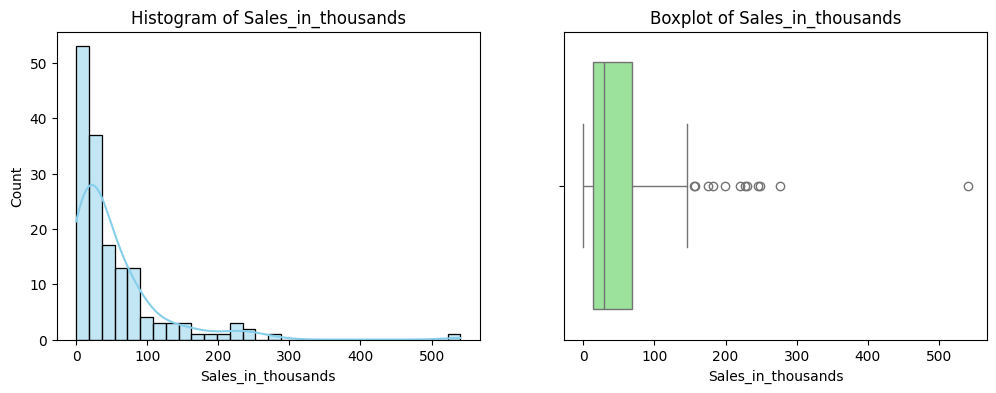


Column: Year_resale_value
Skewness: 2.76
Highly right-skewed


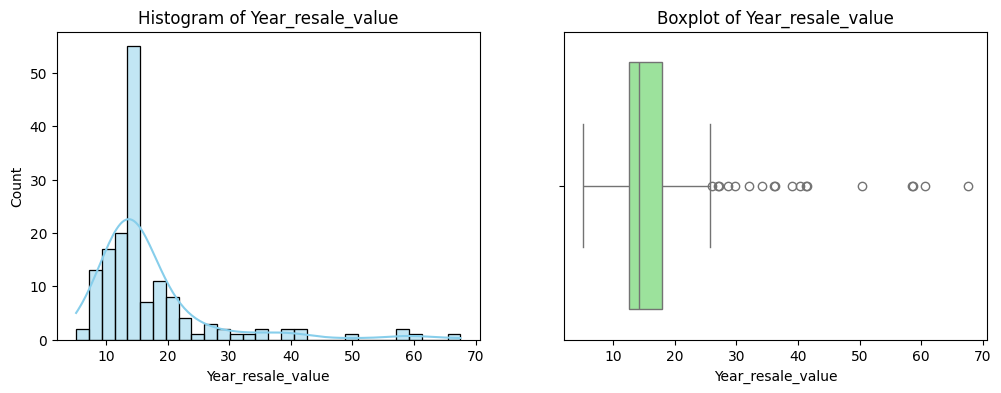


Column: Price_in_thousands
Skewness: 1.78
Highly right-skewed


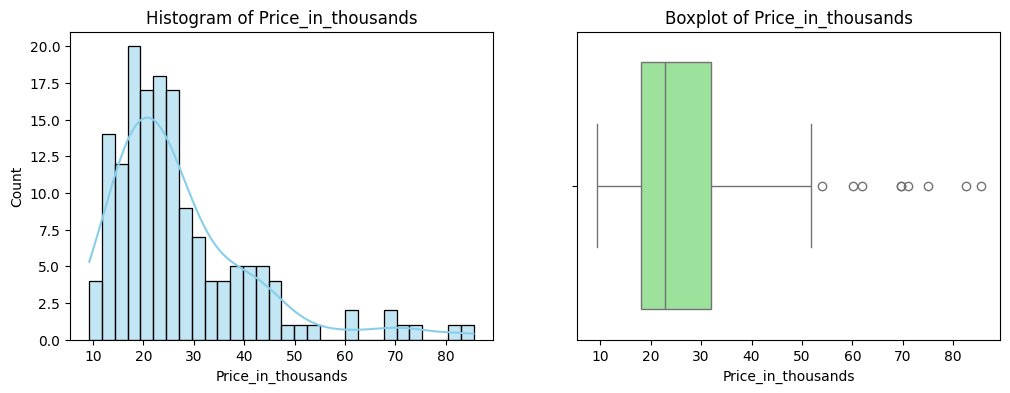


Column: Engine_size
Skewness: 1.10
Highly right-skewed


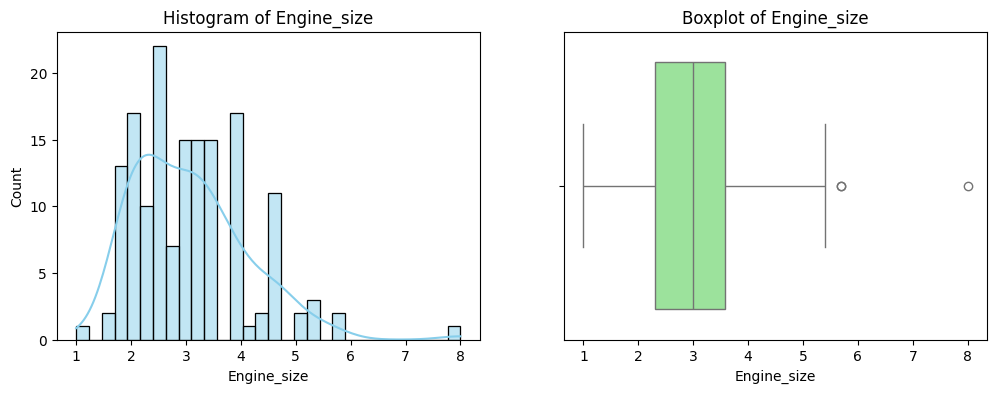


Column: Horsepower
Skewness: 1.00
Highly right-skewed


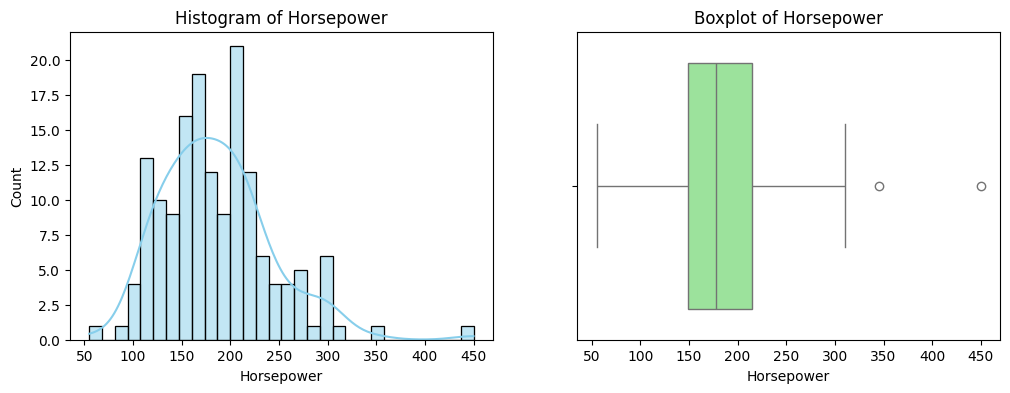


Column: Wheelbase
Skewness: 0.97
Moderately right-skewed


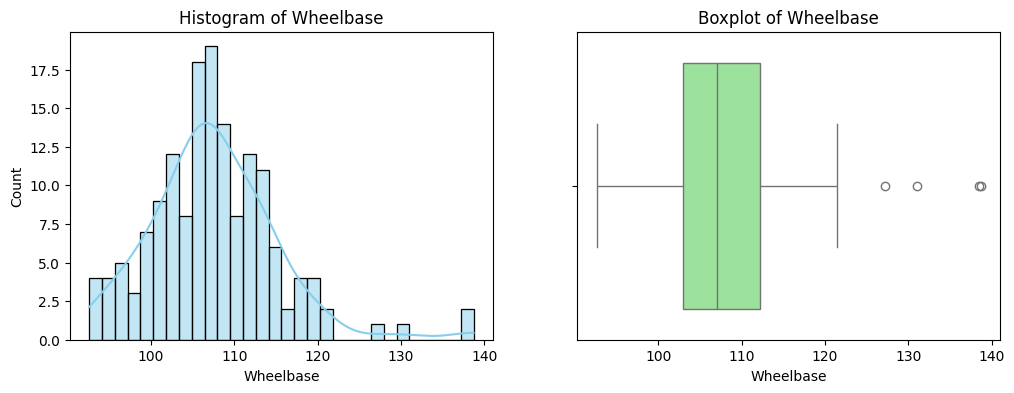


Column: Width
Skewness: 0.48
Approximately symmetric


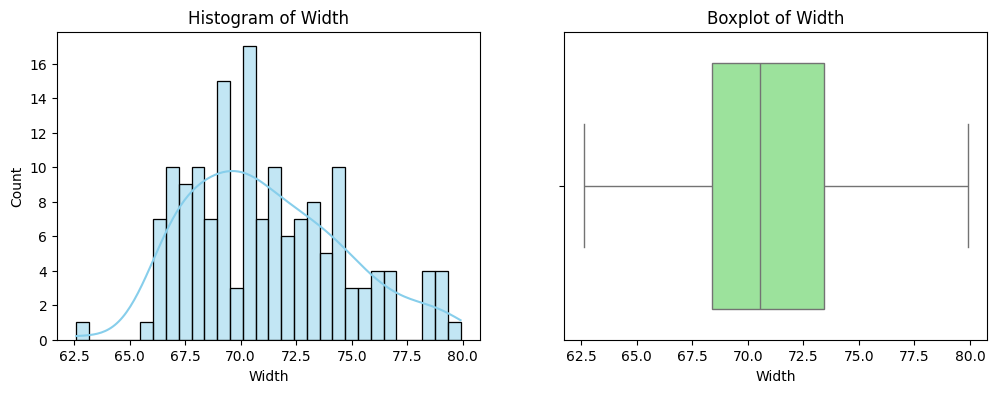


Column: Length
Skewness: -0.06
Approximately symmetric


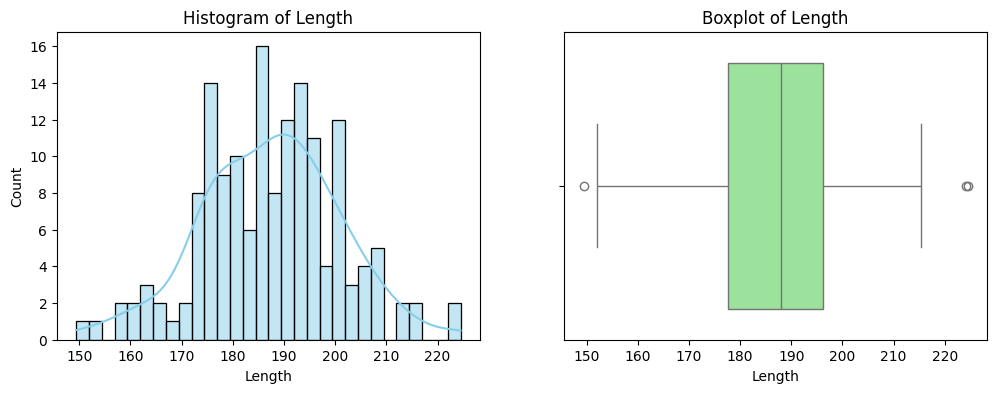


Column: Curb_weight
Skewness: 0.70
Moderately right-skewed


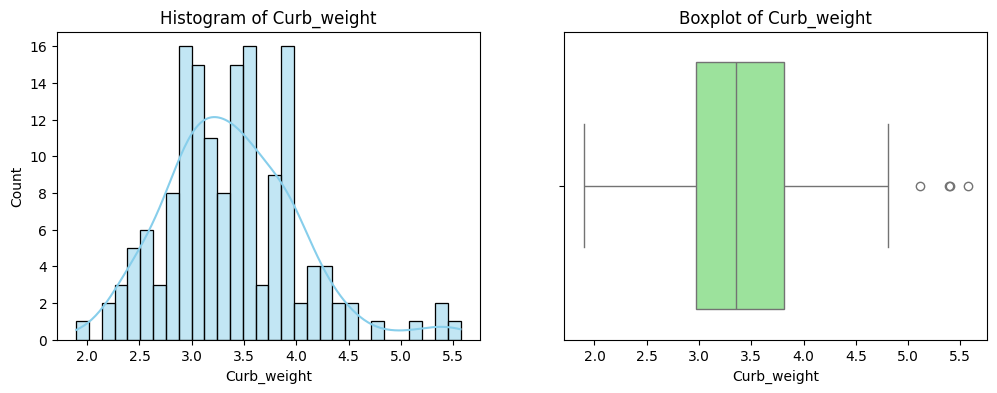


Column: Fuel_capacity
Skewness: 1.14
Highly right-skewed


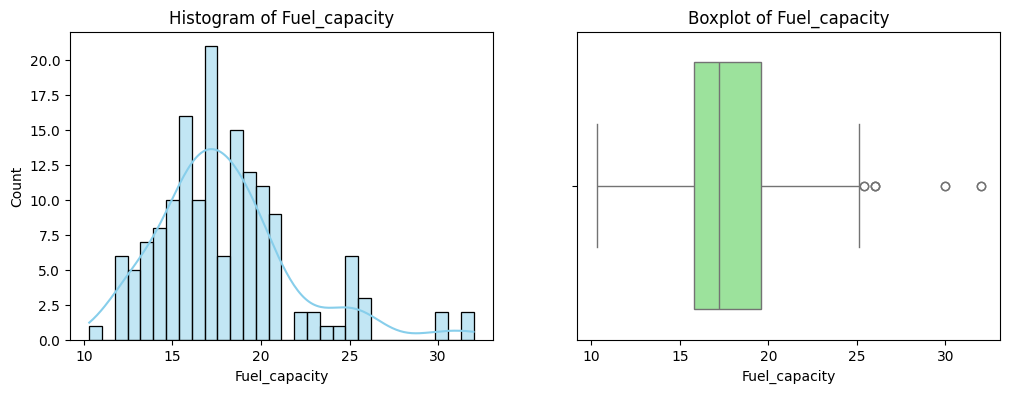


Column: Fuel_efficiency
Skewness: 0.70
Moderately right-skewed


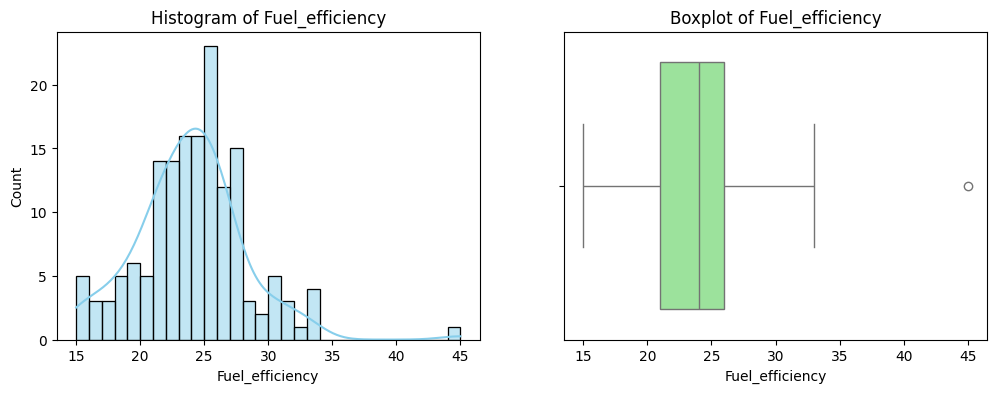


Column: Power_perf_factor
Skewness: 1.08
Highly right-skewed


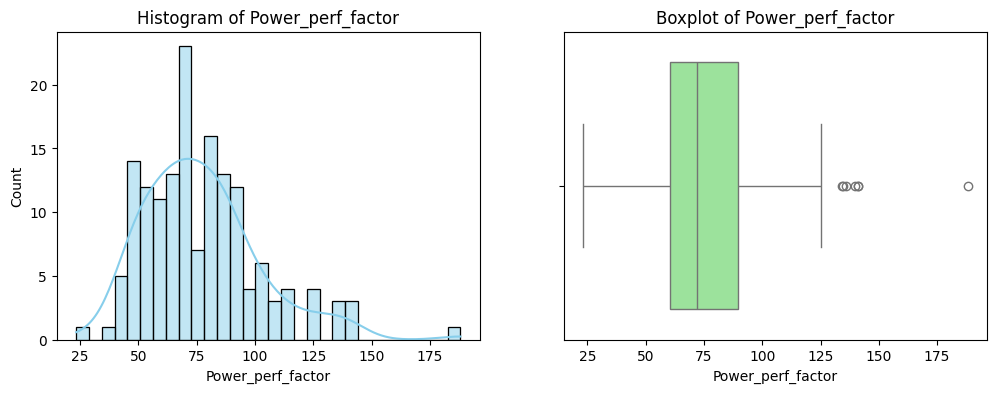

In [47]:
# Numeric Columns Analysis
numeric_cols = df.select_dtypes(include=np.number).columns

for col in numeric_cols:
    skewness = df[col].skew()

    print(f"\nColumn: {col}")
    print(f"Skewness: {skewness:.2f}")
    
    if skewness > 1:
        print("Highly right-skewed")
    elif skewness > 0.5:
        print("Moderately right-skewed")
    elif skewness < -1:
        print("Highly left-skewed")
    elif skewness < -0.5:
        print("Moderately left-skewed")
    else:
        print("Approximately symmetric")
    
    plt.figure(figsize=(12,4))
    
    # Histogram with KDE
    plt.subplot(1,2,1)
    sns.histplot(df[col], bins=30, kde=True, color='skyblue')
    plt.title(f"Histogram of {col}")
    
    # Boxplot
    plt.subplot(1,2,2)
    sns.boxplot(x=df[col], color='lightgreen')
    plt.title(f"Boxplot of {col}")
    
    plt.show()

In [48]:
# Categorical Feature Analysis
manufacturer_count = df['Manufacturer'].value_counts()
print("Manufacturer counts:\n",manufacturer_count)

vehicle_type_count = df['Vehicle_type'].value_counts()
print("Vehicle type counts:\n",vehicle_type_count)


Manufacturer counts:
 Manufacturer
Ford          11
Dodge         11
Chevrolet      9
Mercedes-B     9
Toyota         9
Nissan         7
Mitsubishi     7
Pontiac        6
Mercury        6
Oldsmobile     6
Lexus          6
Chrysler       6
Volvo          6
Volkswagen     6
Cadillac       5
Honda          5
Saturn         5
Plymouth       4
Buick          4
Acura          4
Audi           3
BMW            3
Lincoln        3
Porsche        3
Jeep           3
Hyundai        3
Saab           2
Subaru         2
Jaguar         1
Infiniti       1
Name: count, dtype: int64
Vehicle type counts:
 Vehicle_type
Passenger    116
Car           40
Name: count, dtype: int64


--- CORRELATION HEATMAP FOR ALL NUMERIC COLUMNS ---


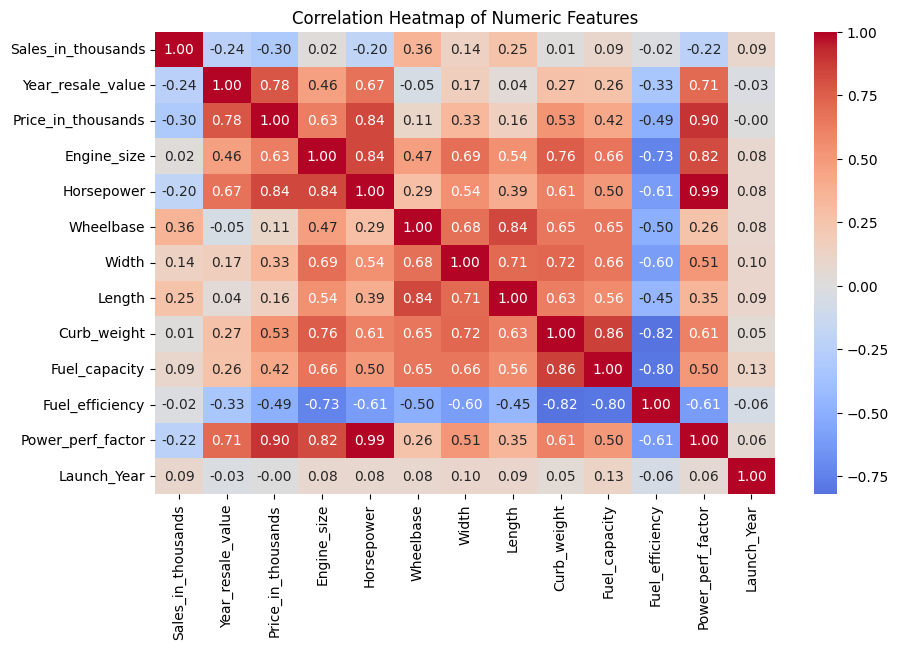

In [109]:
print("--- CORRELATION HEATMAP FOR ALL NUMERIC COLUMNS ---")
# Correlation Heatmap for numeric columns

numeric_cols = df.select_dtypes(include=np.number).columns
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm", center=0, fmt='.2f');
plt.title('Correlation Heatmap of Numeric Features')
plt.show()


--- 1. NUMERIC PRICE DRIVERS ---


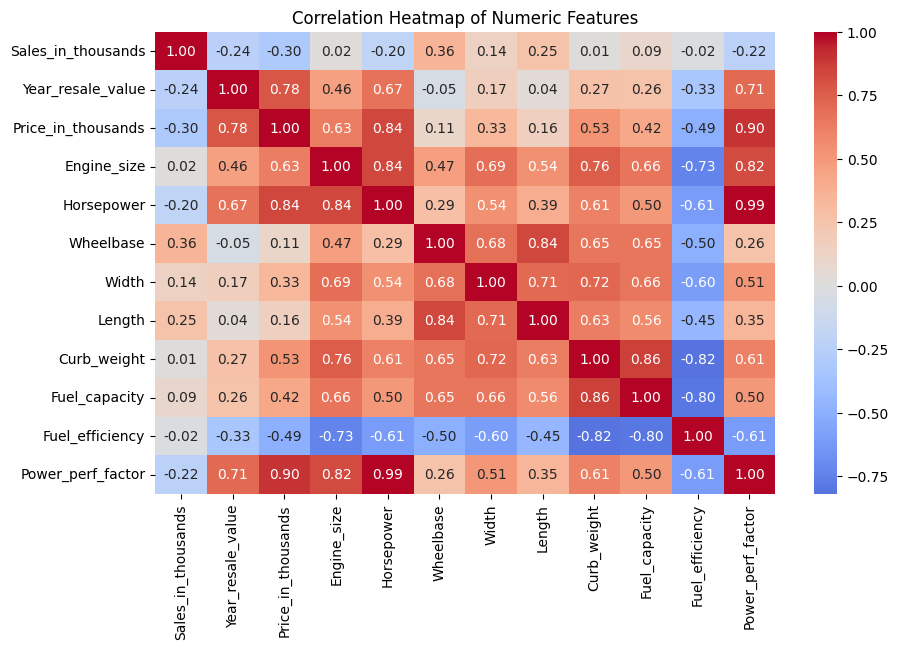

In [49]:
# ----------------------------------------------------------------------
# 1. NUMERIC PRICE DRIVERS (Section 1: Q1, Q2, Q4)
# ----------------------------------------------------------------------

print("--- 1. NUMERIC PRICE DRIVERS ---")

# Correlation Heatmap for numeric columns
#Q1
numeric_cols = df.select_dtypes(include=np.number).columns
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm", center=0, fmt='.2f');
plt.title('Correlation Heatmap of Numeric Features')
plt.show()

# Pairplot of numeric features
#sns.pairplot(df[numeric_cols])
#plt.suptitle("Pairplots of Numeric Features vs Price", y=1.02)
#plt.show()



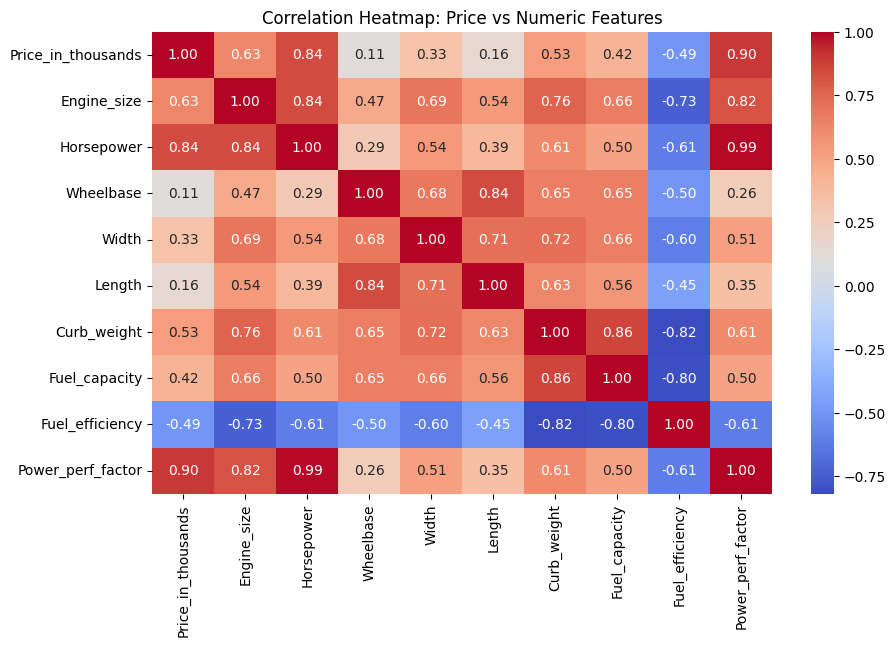

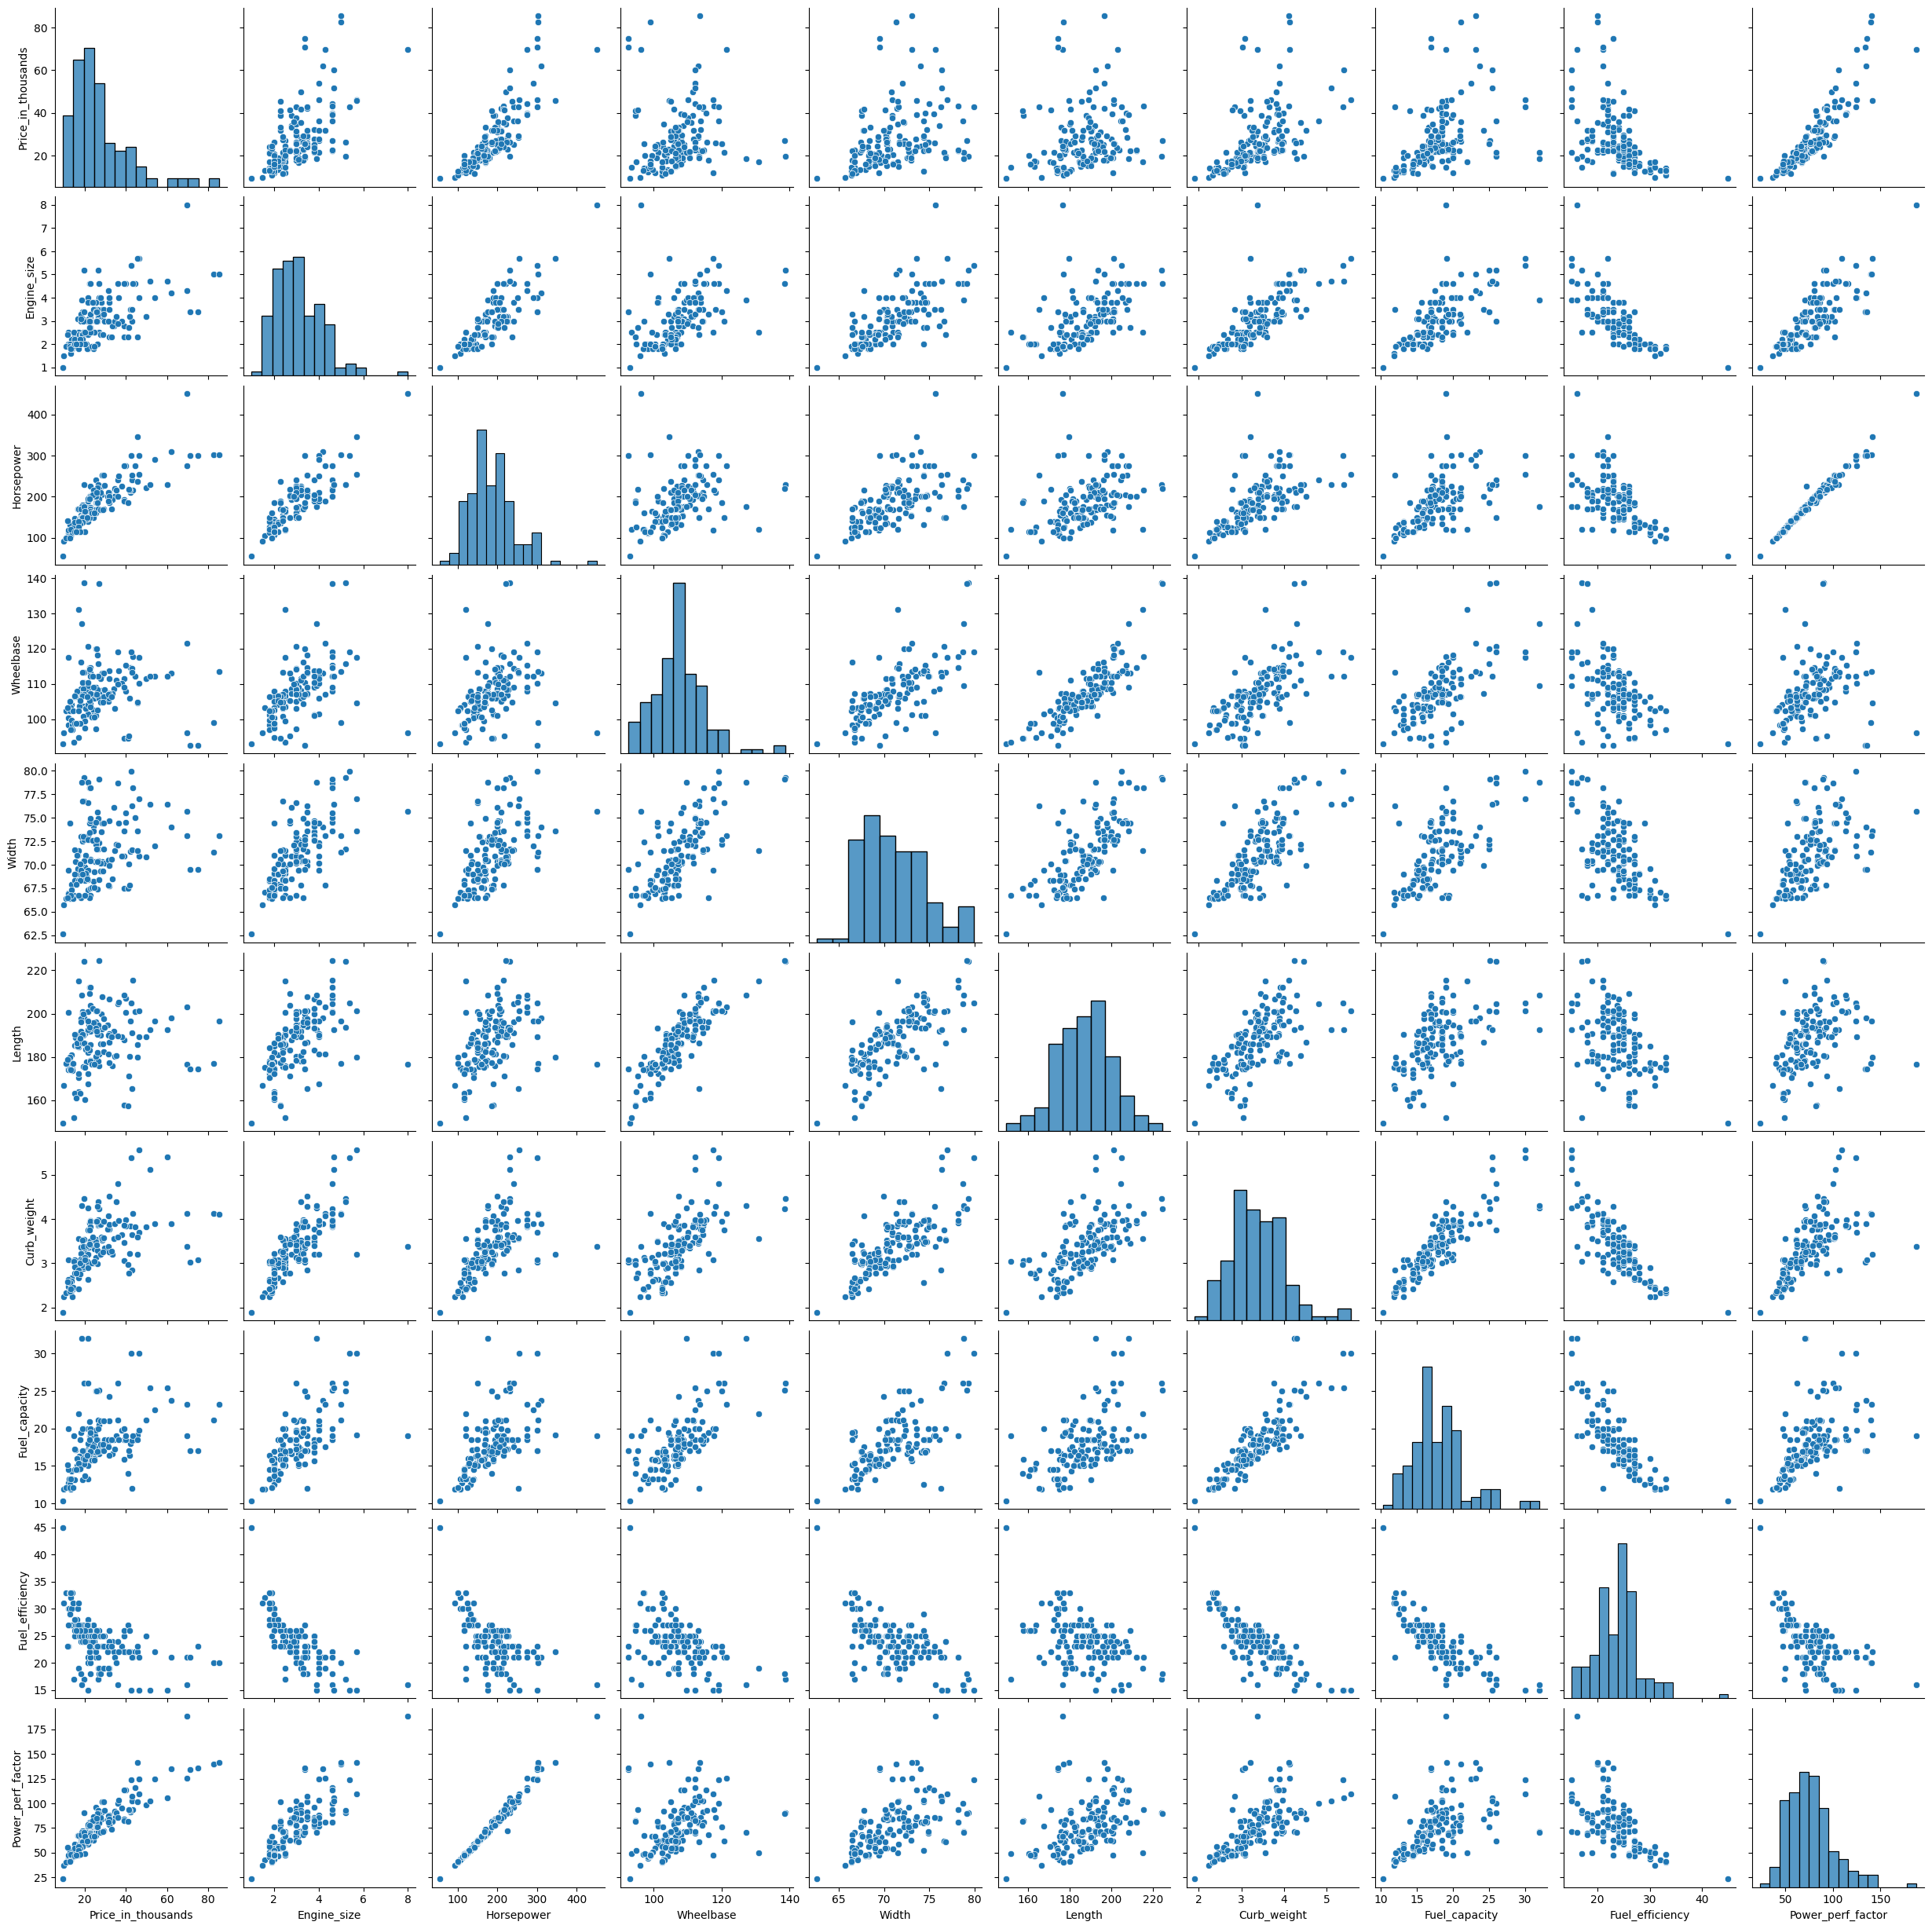

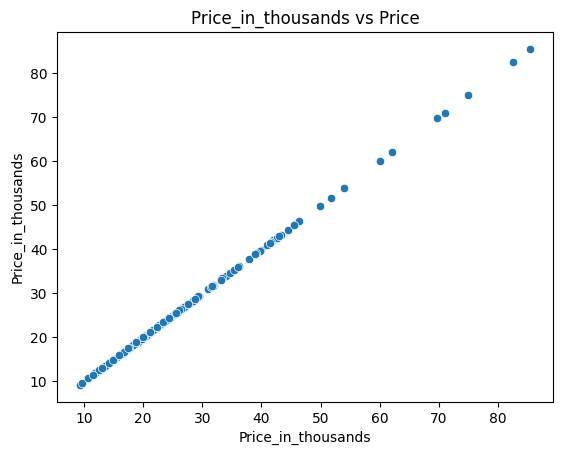

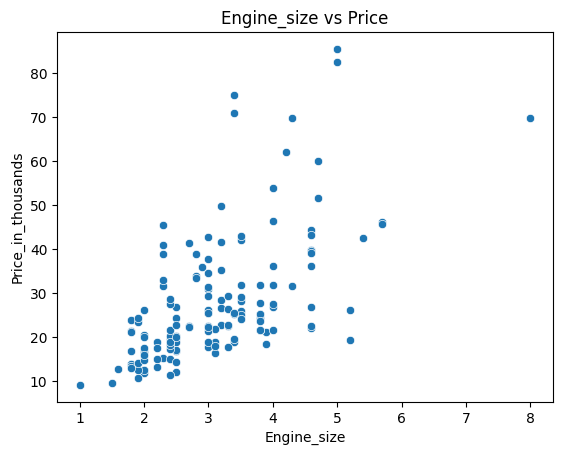

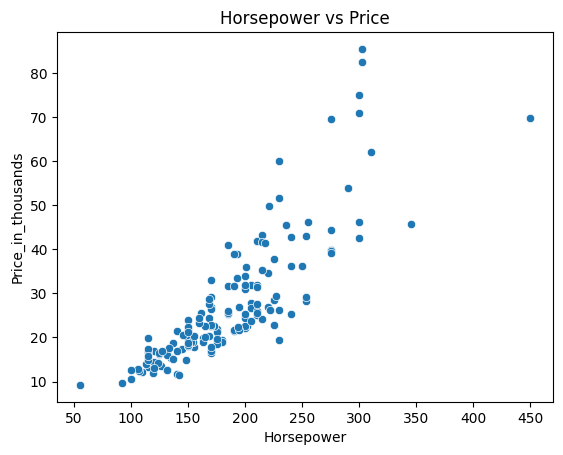

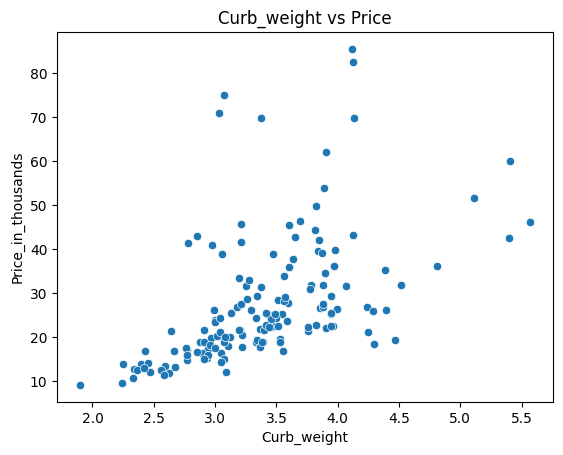

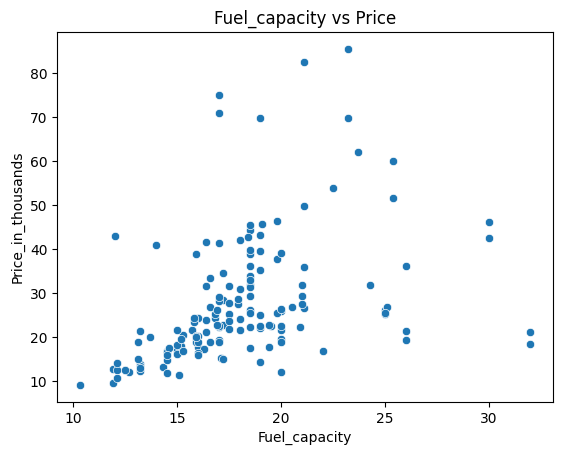

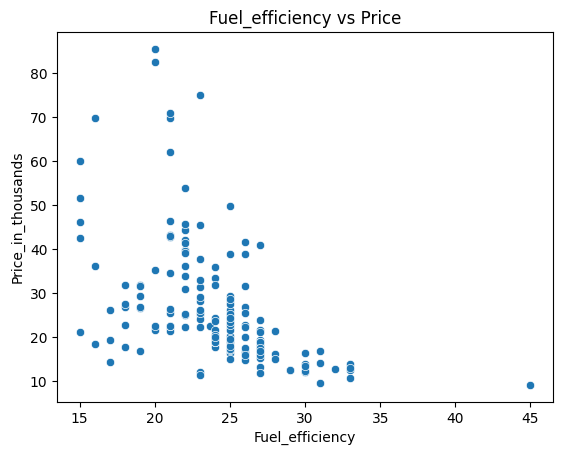

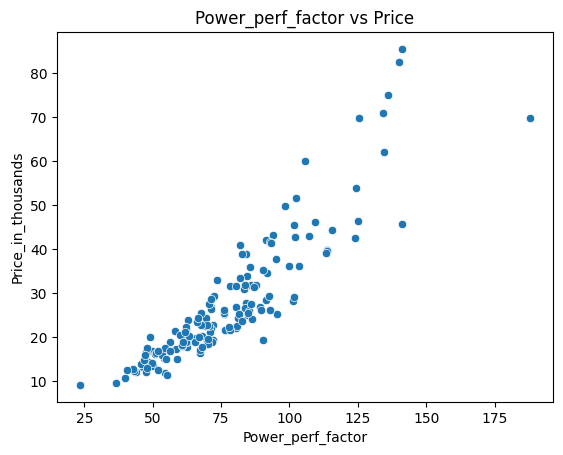

In [ ]:
# Price Analysis (Numeric Features)
# Q 1.1 How strongly are car prices correlated with Horsepower, Engine_size, Curb_weight, Power_perf_factor, Fuel_efficiency and Fuel_capacity
# Selected numeric features
selected_num_features = ["Price_in_thousands", "Engine_size", "Horsepower", "Wheelbase", "Width", "Length",
                         "Curb_weight", "Fuel_capacity", "Fuel_efficiency", "Power_perf_factor"]

# Correlation heatmap
plt.figure(figsize=(10,6))
sns.heatmap(df[selected_num_features].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap: Price vs Numeric Features")
plt.show()

# Pairplot for relationships
sns.pairplot(df[selected_num_features])
plt.show()

# Scatterplots: each numeric vs Price
for feature in ["Price_in_thousands", "Engine_size", "Horsepower",
                "Curb_weight", "Fuel_capacity", "Fuel_efficiency", "Power_perf_factor"]:
    sns.scatterplot(x=feature, y="Price_in_thousands", data=df)
    plt.title(f"{feature} vs Price")
    plt.show()


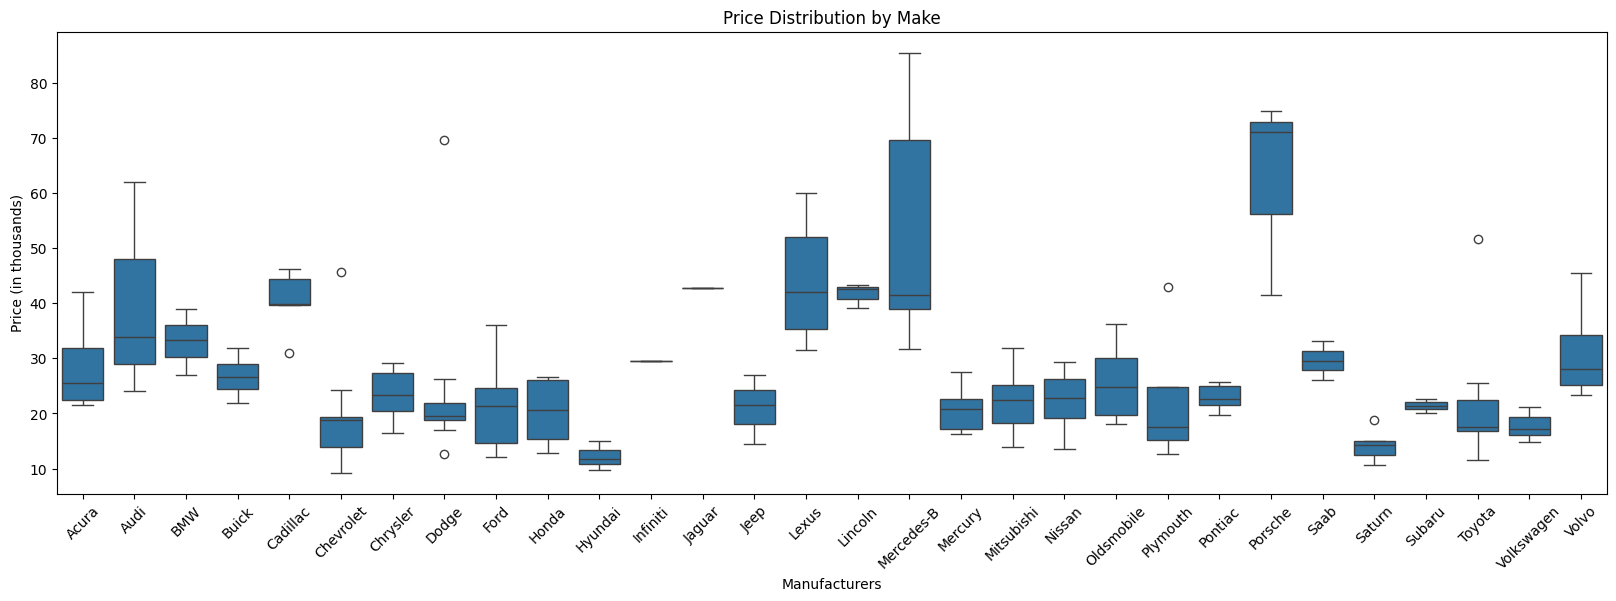

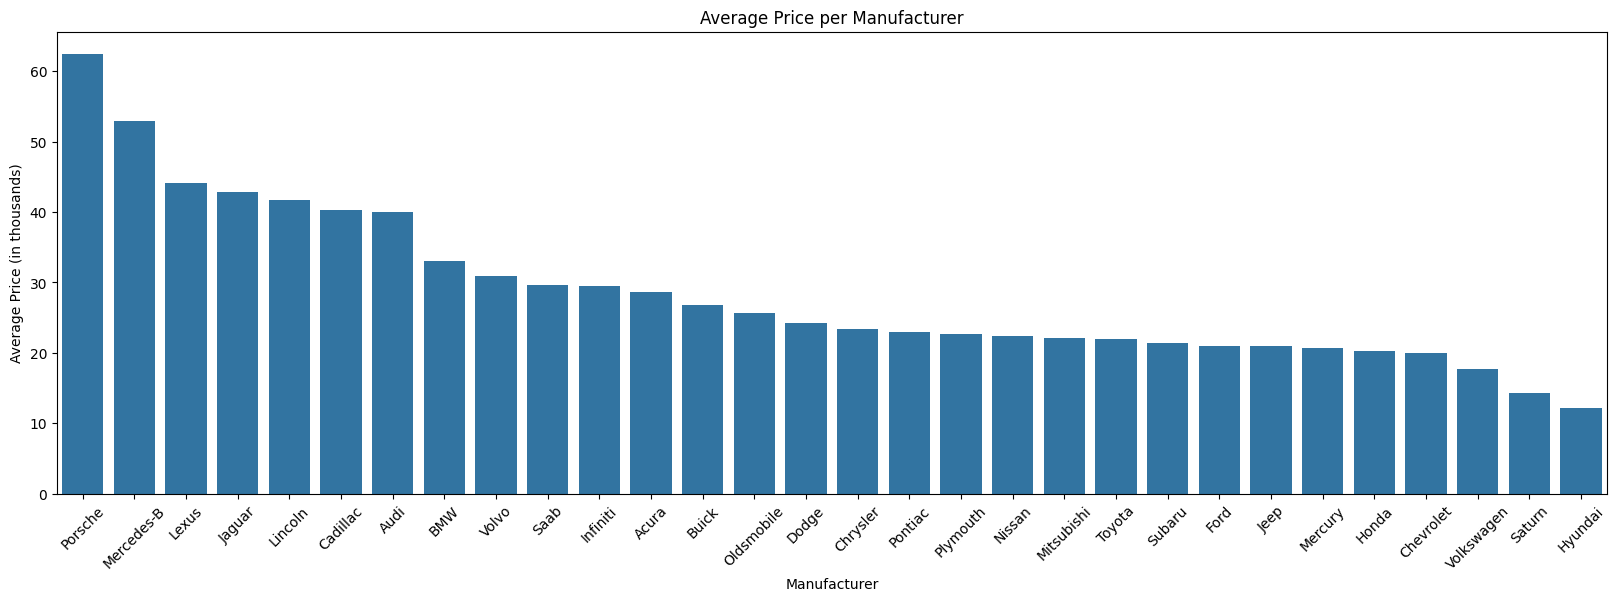

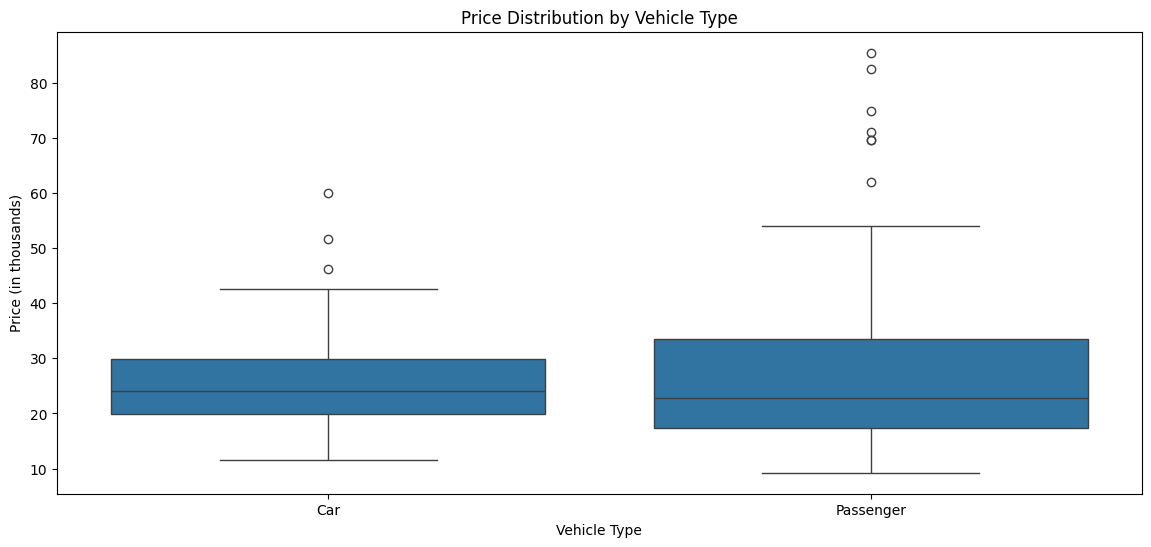


Insights:
1️⃣ Car Makes with Higher Prices:
   - Sorted barplot shows which manufacturers are more expensive on average.
   - Brands on the left (higher bars) tend to have higher prices.
2️⃣ Vehicle Type vs Price:
   - Boxplot shows that SUVs, Sports, and Luxury cars generally have higher prices than Sedans or Hatchbacks.
3️⃣ Additional Insight:
   - Vehicle type has a clear effect on price; price distribution varies significantly between types.


In [ ]:
# Price Analysis (Categorical Features)
# Q 1.2 Does Manufacturer significantly influence Price

# Manufacturer vs Price (Boxplot)
plt.figure(figsize=(20,6))
sns.boxplot(x="Manufacturer", y="Price_in_thousands", data=df)
plt.xticks(rotation=45)
plt.title("Price Distribution by Make")
plt.xlabel("Manufacturers")
plt.ylabel("Price (in thousands)")
plt.show()

# Q 1.3 Which manufacturer tends to have the highest prices
# Average Price per Manufacturer (Barplot)
plt.figure(figsize=(20,6))

# Get the order of manufacturers sorted by mean price
order = df.groupby("Manufacturer", observed=True)["Price_in_thousands"].mean().sort_values(ascending=False).index

# Plot with sorted order
sns.barplot(data=df, x="Manufacturer", y="Price_in_thousands", order=order, errorbar=None)
plt.xticks(rotation=45)
plt.title("Average Price per Manufacturer")
plt.xlabel("Manufacturer")
plt.ylabel("Average Price (in thousands)")
plt.show()

# Q 1.4 Does Vehicle type affect Price
# Vehicle Type vs Price (Boxplot)
plt.figure(figsize=(14,6))
sns.boxplot(data=df, x="Vehicle_type", y="Price_in_thousands")
plt.xticks()
plt.title("Price Distribution by Vehicle Type")
plt.xlabel("Vehicle Type")
plt.ylabel("Price (in thousands)")
plt.show()

# Insights / Answers

print("\nInsights:")
print("1. Car Makes with Higher Prices:")
print("   - Sorted barplot shows which manufacturers are more expensive on average.")
print("   - Brands on the left (higher bars) tend to have higher prices.")
print("2. Vehicle Type vs Price:")
print("   - Boxplot shows that SUVs, Sports, and Luxury cars generally have higher prices than Sedans or Hatchbacks.")
print("3. Additional Insight:")
print("   - Vehicle type has a clear effect on price; price distribution varies significantly between types.")


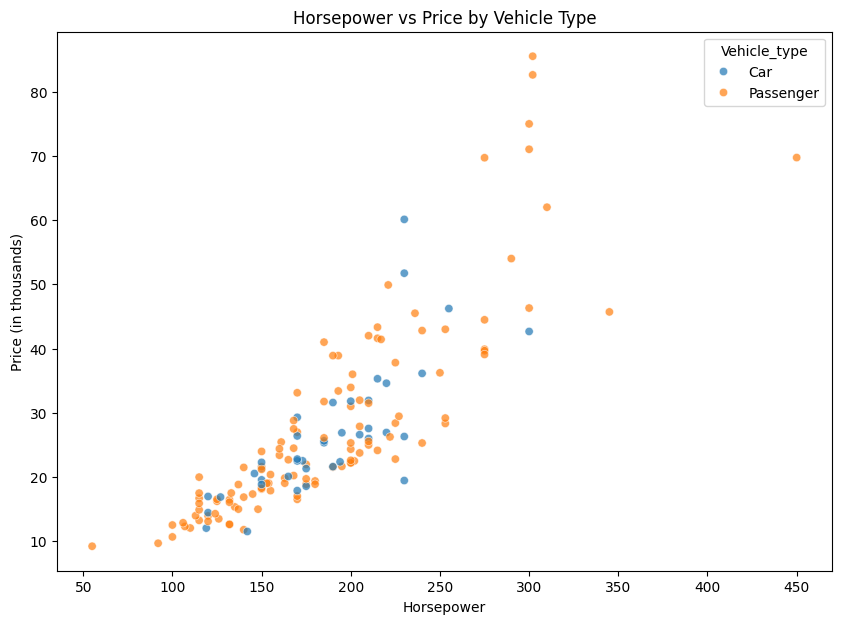

In [135]:
# Q 1.5 How does Horsepower relate to Price
# Scatterplot: Horsepower vs Price by Vehicle_Type

plt.figure(figsize=(10, 7))
sns.scatterplot(data=df, x='Horsepower', y='Price_in_thousands', hue='Vehicle_type', alpha=0.7)
plt.title("Horsepower vs Price by Vehicle Type")
plt.xlabel("Horsepower")
plt.ylabel("Price (in thousands)")
plt.show()

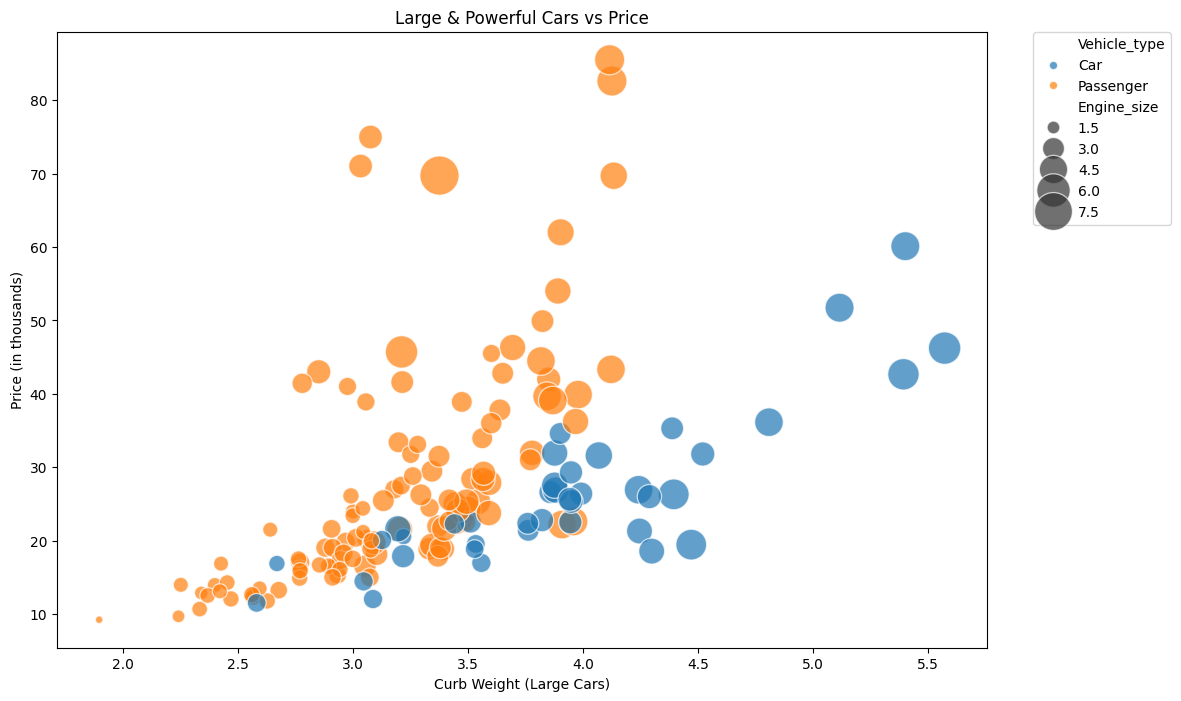

In [150]:
# Q 1.6 Do large/more powerful cars command higher prices?
# 1.3 Scatterplot: Price vs. Curb Weight (The Size Driver)
#plt.figure(figsize=(16,6))

# --- Plot 1: Curb Weight vs Price ---
#plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st plot
#sns.scatterplot(data=df, x='Curb_weight', y='Price_in_thousands', hue='Vehicle_type', alpha=0.7)
#plt.title('Curb Weight vs Price')
#plt.xlabel('Curb Weight')
#plt.ylabel('Price (in thousands)')

# --- Plot 2: Engine Size vs Price ---
#plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd plot
#sns.scatterplot(data=df, x='Engine_size', y='Price_in_thousands', hue='Vehicle_type', alpha=0.7, palette='tab10')
#plt.title('Engine Size vs Price')
#plt.xlabel('Engine Size')
#plt.ylabel('Price (in thousands)')

#plt.tight_layout()
#plt.show()

plt.figure(figsize=(12,8))

sns.scatterplot(
    data=df,
    x='Curb_weight',           # Large
    y='Price_in_thousands',    # Price
    size='Engine_size',        # Powerful
    hue='Vehicle_type',        # Vehicle Type for color
    alpha=0.7,
    sizes=(30, 800)            # min/max bubble size
);

plt.title("Large & Powerful Cars vs Price")
plt.xlabel("Curb Weight (Large Cars)")
plt.ylabel("Price (in thousands)")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)  # Move legend outside
plt.show()

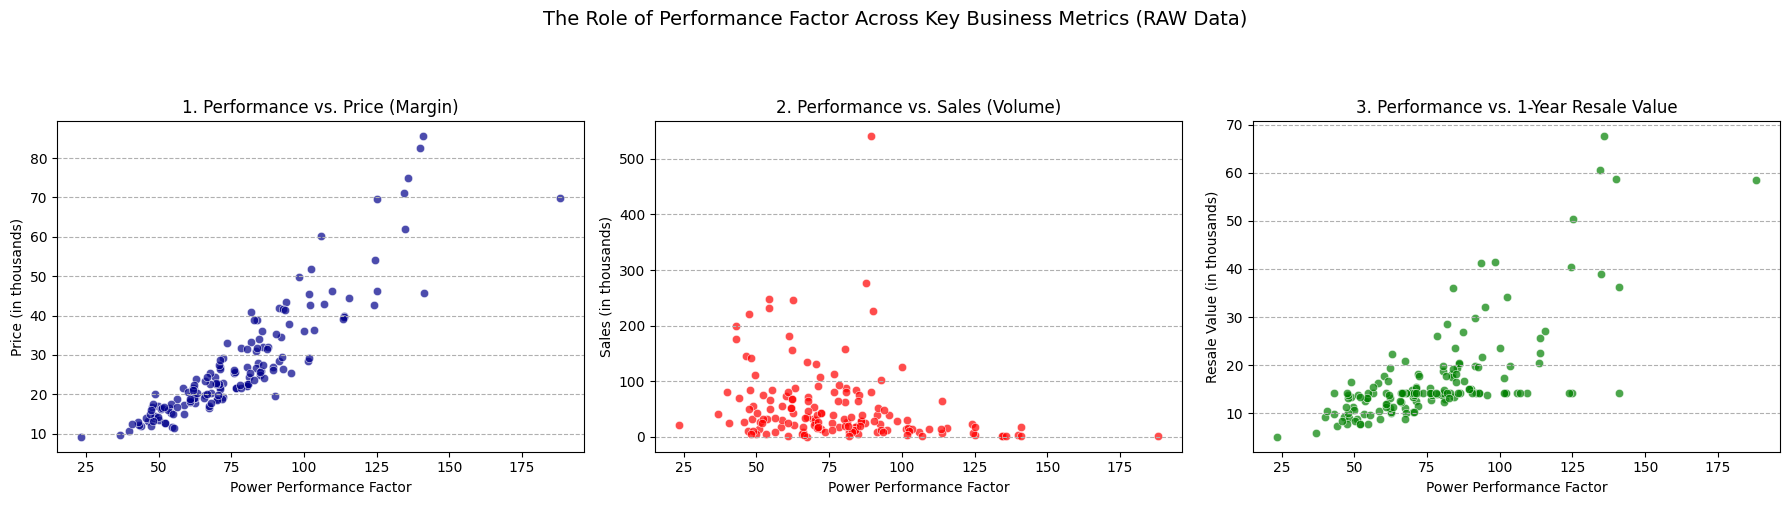

In [ ]:
#DONOT DELETE
# Q 4 Is Power_perf_factor correlated with Price
# ----------------------------------------------------------------------
# ANALYSIS: Power_perf_factor vs. Key Business Metrics
# Addresses: Performance correlation with Price (Sect 1), Sales (Sect 2), and Resale (Sect 3).
# ----------------------------------------------------------------------


fig, ax = plt.subplots(1, 3, figsize=(18, 5))
plt.suptitle("The Role of Performance Factor Across Key Business Metrics (RAW Data)", fontsize=14, y=1.03)

# Plot 1: Price (Margin)
sns.scatterplot(x='Power_perf_factor', y='Price_in_thousands', data=df, ax=ax[0], color='darkblue', alpha=0.7)
ax[0].set_title("1. Performance vs. Price (Margin)")
ax[0].set_xlabel("Power Performance Factor")
ax[0].set_ylabel("Price (in thousands)")
ax[0].grid(axis='y', linestyle='--')

# Plot 2: Sales (Volume)
sns.scatterplot(x='Power_perf_factor', y='Sales_in_thousands', data=df, ax=ax[1], color='red', alpha=0.7)
ax[1].set_title("2. Performance vs. Sales (Volume)")
ax[1].set_xlabel("Power Performance Factor")
ax[1].set_ylabel("Sales (in thousands)")
ax[1].grid(axis='y', linestyle='--')

# Plot 3: Resale Value (Retention)
sns.scatterplot(x='Power_perf_factor', y='Year_resale_value', data=df, ax=ax[2], color='green', alpha=0.7)
ax[2].set_title("3. Performance vs. 1-Year Resale Value")
ax[2].set_xlabel("Power Performance Factor")
ax[2].set_ylabel("Resale Value (in thousands)")
ax[2].grid(axis='y', linestyle='--')

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make room for suptitle
plt.show()


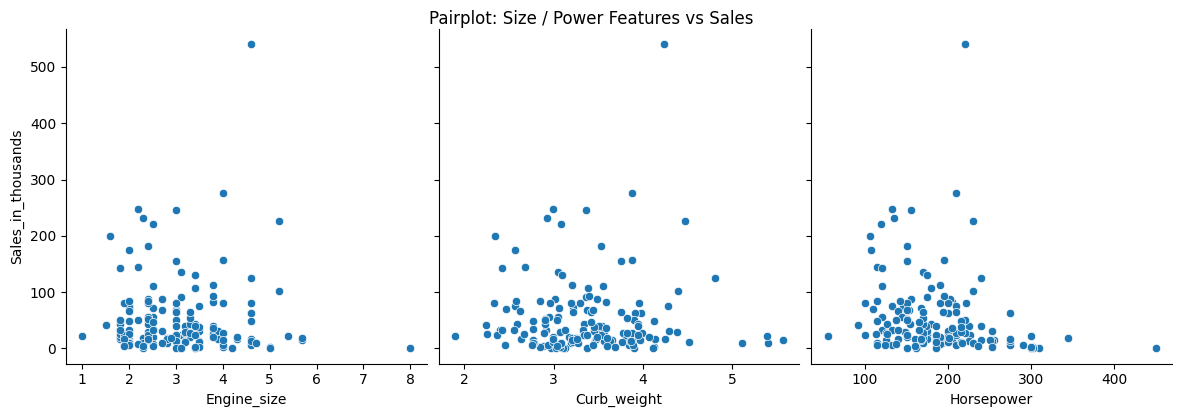

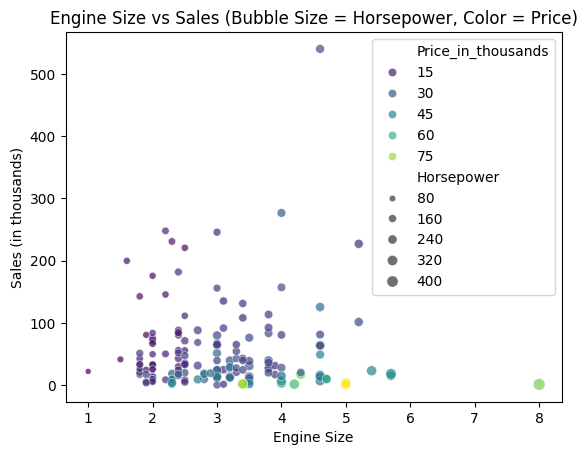

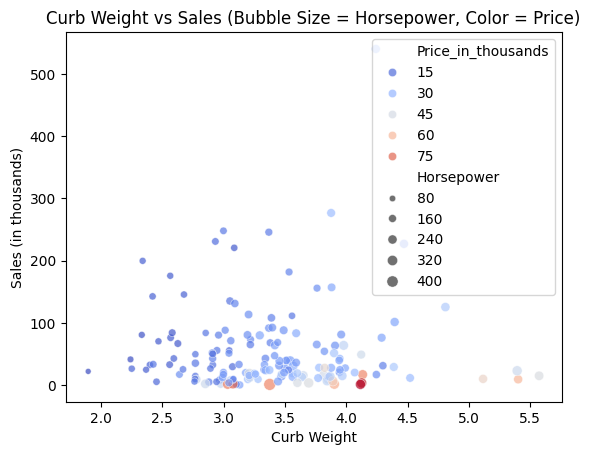

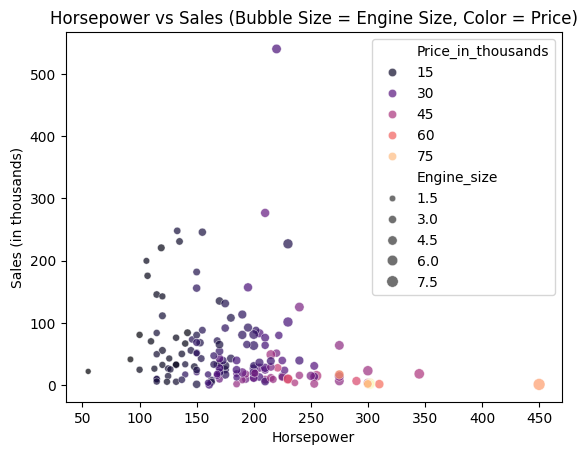

In [54]:
# --------------------------
# Step 7: Sales vs Size / Power (Refactored)
# --------------------------
df_sales = df[["Sales_in_thousands", "Engine_size", "Curb_weight", "Horsepower", "Price_in_thousands"]]

# 1️⃣ Quick exploration: Pairplot
sns.pairplot(df_sales, x_vars=["Engine_size","Curb_weight","Horsepower"], 
             y_vars=["Sales_in_thousands"], height=4, aspect=1, kind="scatter")
plt.suptitle("Pairplot: Size / Power Features vs Sales", y=1.02)
plt.show()

# 2️⃣ Key individual scatterplots (customized for clarity)

# Engine_size vs Sales
sns.scatterplot(data=df_sales, x="Engine_size", y="Sales_in_thousands", 
                size="Horsepower", hue="Price_in_thousands", palette="viridis", alpha=0.7)
plt.title("Engine Size vs Sales (Bubble Size = Horsepower, Color = Price)")
plt.xlabel("Engine Size")
plt.ylabel("Sales (in thousands)")
plt.show()

# Curb_weight vs Sales
sns.scatterplot(data=df_sales, x="Curb_weight", y="Sales_in_thousands", 
                size="Horsepower", hue="Price_in_thousands", palette="coolwarm", alpha=0.7)
plt.title("Curb Weight vs Sales (Bubble Size = Horsepower, Color = Price)")
plt.xlabel("Curb Weight")
plt.ylabel("Sales (in thousands)")
plt.show()

# Horsepower vs Sales
sns.scatterplot(data=df_sales, x="Horsepower", y="Sales_in_thousands", 
                size="Engine_size", hue="Price_in_thousands", palette="magma", alpha=0.7)
plt.title("Horsepower vs Sales (Bubble Size = Engine Size, Color = Price)")
plt.xlabel("Horsepower")
plt.ylabel("Sales (in thousands)")
plt.show()


--- 1. Initial Exploration: Pairplot ---


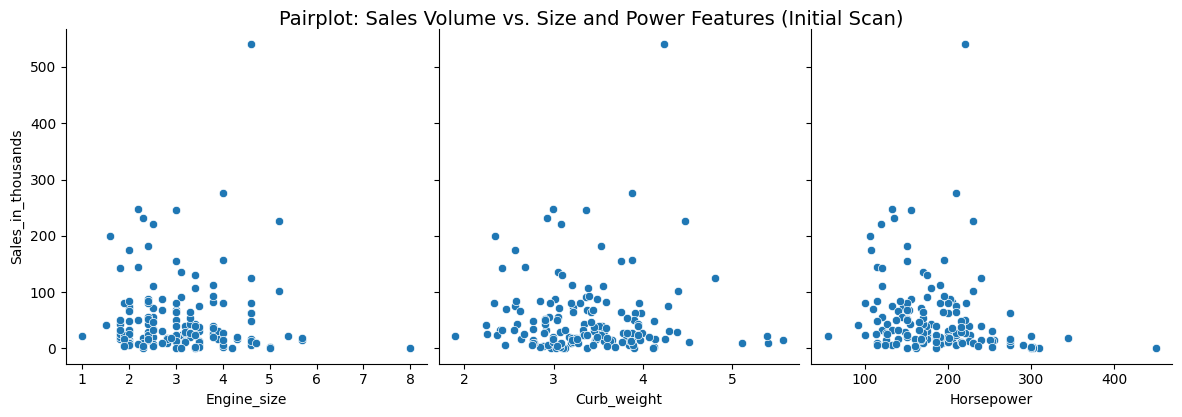


--- 2. Detailed Analysis: Consolidated Scatterplots ---


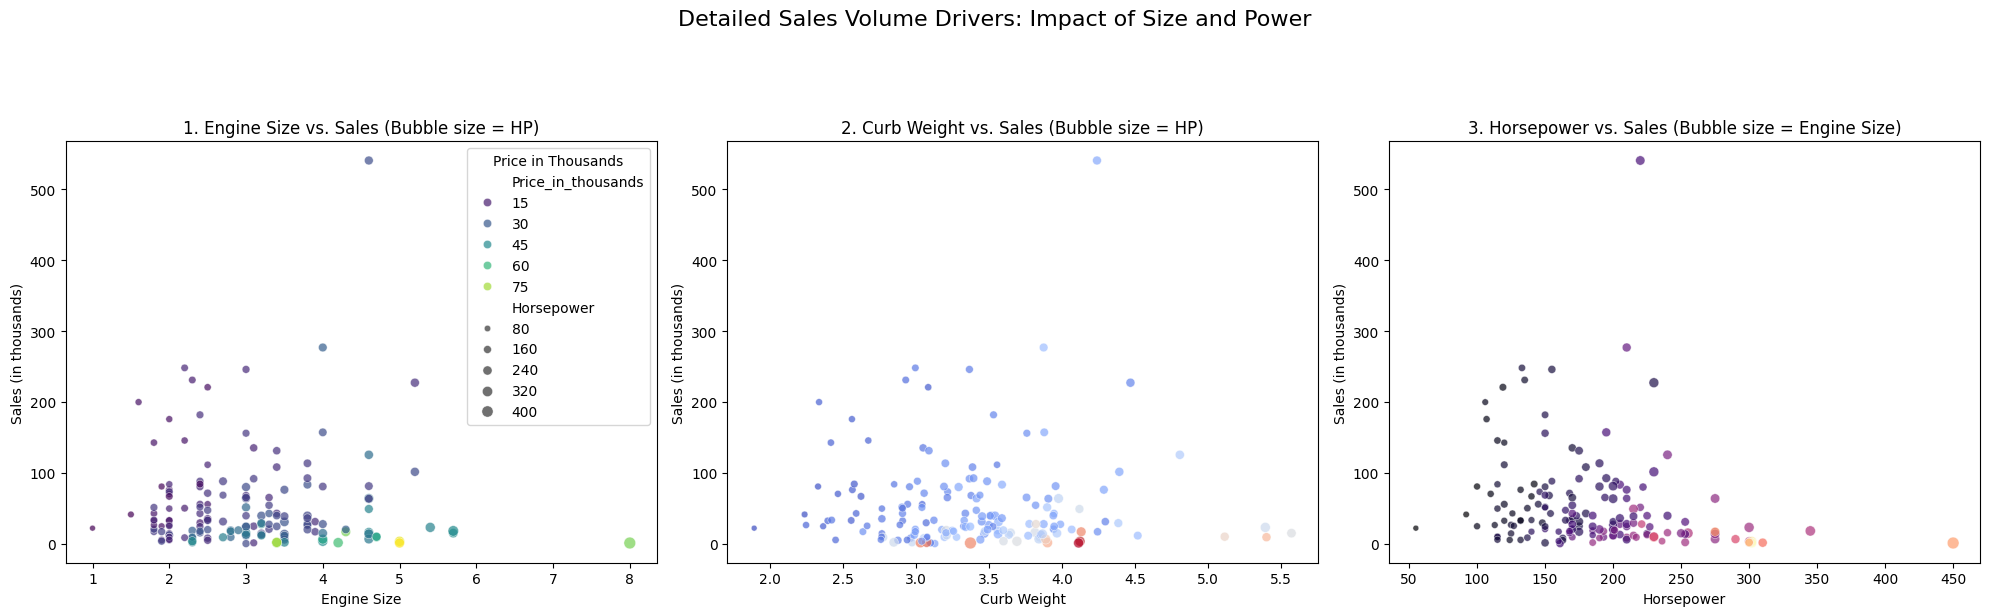

In [55]:
# ----------------------------------------------------------------------
# STEP 7: SALES VS SIZE / POWER ANALYSIS (Visual Refinement)
# Goal: Consolidate individual scatterplots into a clean, multi-plot figure.
# ----------------------------------------------------------------------

# Prepare Data
# Dropping rows with any missing values in the analysis subset
df_sales = df[["Sales_in_thousands", "Engine_size", "Curb_weight", "Horsepower", "Price_in_thousands"]].dropna()


# 1. Initial Exploration: Pairplot
# Provides a quick, high-level view of all relationships with Sales.
print("--- 1. Initial Exploration: Pairplot ---")
sns.pairplot(df_sales, 
             x_vars=["Engine_size", "Curb_weight", "Horsepower"], 
             y_vars=["Sales_in_thousands"], 
             height=4, aspect=1, kind="scatter")
plt.suptitle("Pairplot: Sales Volume vs. Size and Power Features (Initial Scan)", y=1.02, fontsize=14)
plt.show()


# 2. Detailed Analysis: Consolidated Scatterplots
# This provides three rich, focused views in a single, professional figure.
print("\n--- 2. Detailed Analysis: Consolidated Scatterplots ---")

fig, axes = plt.subplots(1, 3, figsize=(20, 6))
plt.suptitle("Detailed Sales Volume Drivers: Impact of Size and Power", fontsize=16, y=1.05)

# --- Plot 1: Engine Size vs Sales ---
sns.scatterplot(
    data=df_sales, 
    x="Engine_size", 
    y="Sales_in_thousands", 
    size="Horsepower",       
    hue="Price_in_thousands", 
    palette="viridis", 
    alpha=0.7,
    ax=axes[0]
)
axes[0].set_title("1. Engine Size vs. Sales (Bubble size = HP)", fontsize=12)
axes[0].set_xlabel("Engine Size")
axes[0].set_ylabel("Sales (in thousands)")
# Keep one comprehensive legend on the first plot
axes[0].legend(title="Price in Thousands", loc='upper right') 

# --- Plot 2: Curb Weight vs Sales ---
sns.scatterplot(
    data=df_sales, 
    x="Curb_weight", 
    y="Sales_in_thousands", 
    size="Horsepower",
    hue="Price_in_thousands",
    palette="coolwarm", 
    alpha=0.7,
    ax=axes[1]
)
axes[1].set_title("2. Curb Weight vs. Sales (Bubble size = HP)", fontsize=12)
axes[1].set_xlabel("Curb Weight")
axes[1].set_ylabel("Sales (in thousands)")
axes[1].legend([],[], frameon=False) # Remove redundant legend

# --- Plot 3: Horsepower vs Sales ---
sns.scatterplot(
    data=df_sales, 
    x="Horsepower", 
    y="Sales_in_thousands", 
    size="Engine_size",      
    hue="Price_in_thousands", 
    palette="magma", 
    alpha=0.7,
    ax=axes[2]
)
axes[2].set_title("3. Horsepower vs. Sales (Bubble size = Engine Size)", fontsize=12)
axes[2].set_xlabel("Horsepower")
axes[2].set_ylabel("Sales (in thousands)")
axes[2].legend([],[], frameon=False) # Remove redundant legend


plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

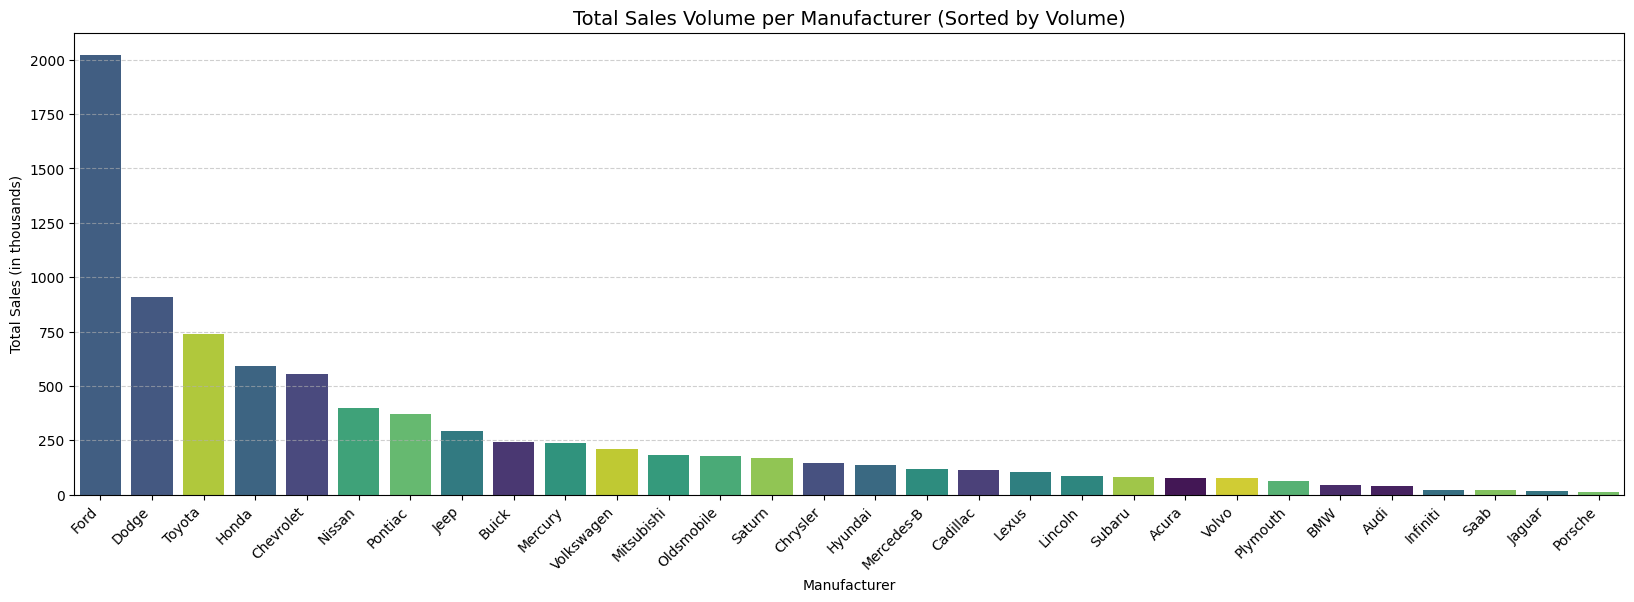

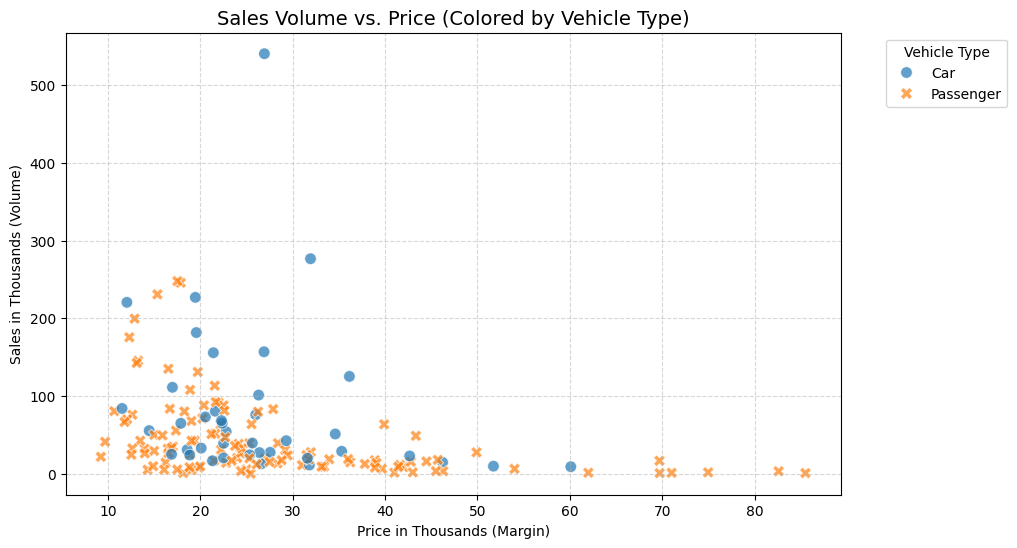

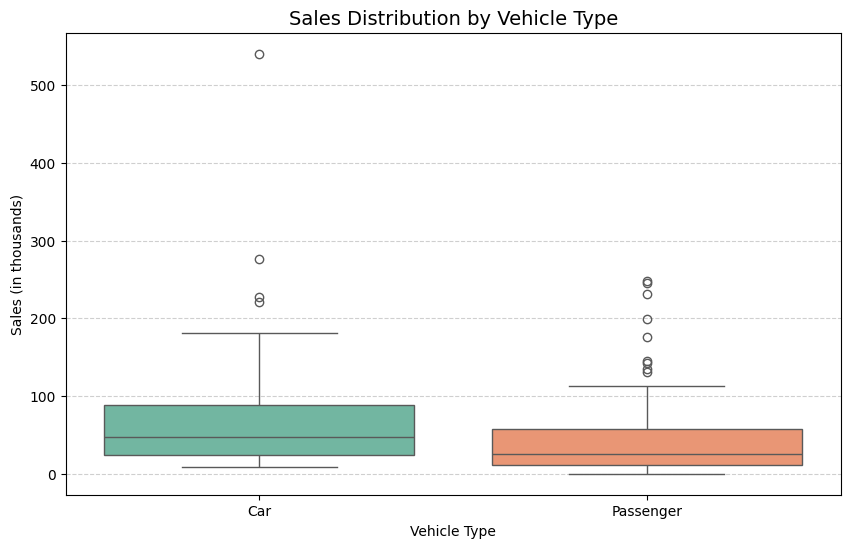


--- Q2.1 Market Dynamics: Sales and Price Trend ---


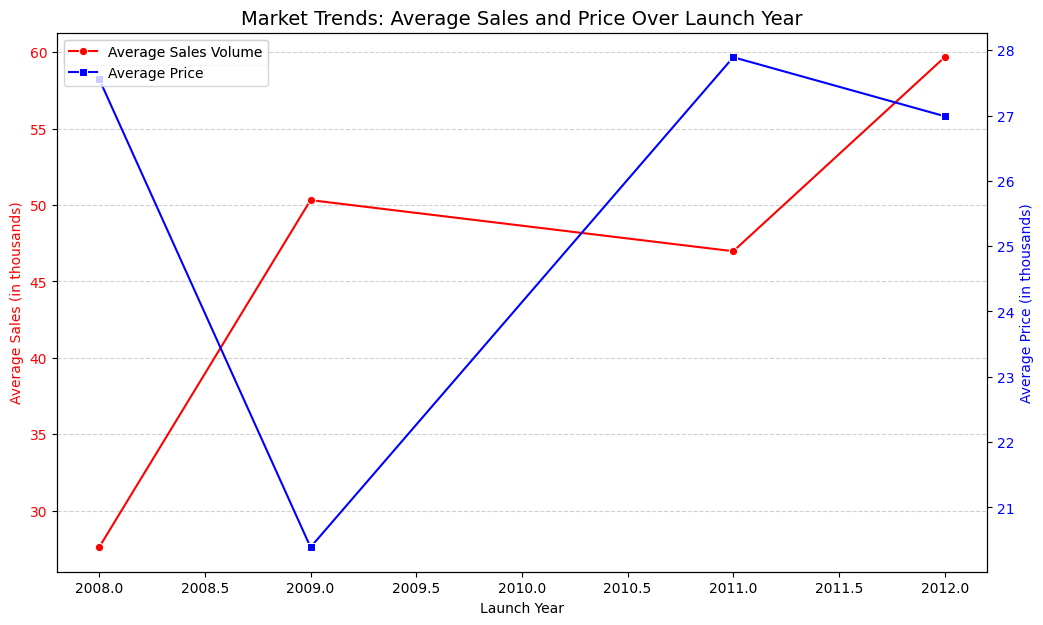

In [104]:
# ----------------------------------------------------------------------
# PHASE 1, SECTION 2: SALES & MARKET TRENDS (Final Consolidated Code)
# ----------------------------------------------------------------------

# --- Q1 Theme: Market Dominance & Segmentation (Volume) ---

# Q1.1: Which manufacturers dominate the total sales volume? (Barplot - Guaranteed Sorted)
# ----------------------------------------------------------------------
plt.figure(figsize=(20, 6))

# 1. Aggregate and sort by sales (creates the small, sorted summary table)
manufacturer_sales_df = (
    df.groupby('Manufacturer', observed=True)['Sales_in_thousands']
      .sum()
      .sort_values(ascending=False)
      .reset_index()
)

# 2. Extract the sorted list of Manufacturer names for explicit order
manufacturer_order_list = manufacturer_sales_df['Manufacturer']

# 3. Plotting the PRE-SORTED DataFrame with explicit order
sns.barplot(
    data=manufacturer_sales_df,
    x="Manufacturer",
    y="Sales_in_thousands",
    order=manufacturer_order_list, # GUARANTEES THE SORTING
    hue="Manufacturer", 
    legend=False,
    palette='viridis' 
)

plt.xticks(rotation=45, ha='right')
plt.title("Total Sales Volume per Manufacturer (Sorted by Volume)", fontsize=14)
plt.xlabel("Manufacturer")
plt.ylabel("Total Sales (in thousands)")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


# Q1.2: What is the relationship between Price and Sales Volume? 
# (Scatterplot/Bubble Chart for Price/Volume clusters)
# ----------------------------------------------------------------------
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df, 
    x='Price_in_thousands', 
    y='Sales_in_thousands', 
    hue='Vehicle_type',
    style='Vehicle_type',
    s=70, 
    alpha=0.7
)
plt.title('Sales Volume vs. Price (Colored by Vehicle Type)', fontsize=14)
plt.xlabel('Price in Thousands (Margin)')
plt.ylabel('Sales in Thousands (Volume)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, title='Vehicle Type')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


# Q1.3: Are sales linked to Vehicle_Type? (Boxplot for Sales Distribution)
# ----------------------------------------------------------------------
plt.figure(figsize=(10, 6))

sns.boxplot(
    data=df, 
    x='Vehicle_type',
    y='Sales_in_thousands',
    hue='Vehicle_type',
    legend=False,
    palette='Set2'
)

plt.xticks(rotation=0)
plt.title('Sales Distribution by Vehicle Type', fontsize=14)
plt.xlabel('Vehicle Type')
plt.ylabel('Sales (in thousands)')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


# --- Q2 Theme: Market Dynamics (Time) ---

# Q2.1: How have average Sales and average Prices trended over the years of new launches? 
# (Dual-Axis Line Plot)
# ----------------------------------------------------------------------

print("\n--- Q2.1 Market Dynamics: Sales and Price Trend ---")

# Ensure 'Launch_Year' is available
if 'Latest_Launch' in df.columns and 'Launch_Year' not in df.columns:
    df['Launch_Year'] = df['Latest_Launch'].dt.year

# Calculate average sales and price per year
df_trend = df.groupby('Launch_Year', observed=True)[['Sales_in_thousands', 'Price_in_thousands']].mean().reset_index().dropna()

plt.figure(figsize=(12, 7))

# Create the figure and the primary axis (ax1) for Sales
ax1 = plt.gca() 

# Sales Trend (Primary Y-axis)
sns.lineplot(
    data=df_trend, 
    x='Launch_Year', 
    y='Sales_in_thousands', 
    label='Average Sales Volume', 
    marker='o', 
    color='red',
    ax=ax1
)
ax1.set_ylabel('Average Sales (in thousands)', color='red')
ax1.tick_params(axis='y', labelcolor='red')

# Create the secondary axis (ax2) that shares the same X-axis
ax2 = ax1.twinx() 

# Price Trend (Secondary Y-axis)
sns.lineplot(
    data=df_trend, 
    x='Launch_Year', 
    y='Price_in_thousands', 
    label='Average Price', 
    marker='s', 
    color='blue', 
    ax=ax2
)
ax2.set_ylabel('Average Price (in thousands)', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

# Final formatting
ax1.set_title('Market Trends: Average Sales and Price Over Launch Year', fontsize=14)
ax1.set_xlabel('Launch Year')
ax1.grid(True, linestyle='--', alpha=0.6, axis='y')

# Combine legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

plt.show()


--- 1.1 Resale Value: Key Numeric Correlations ---


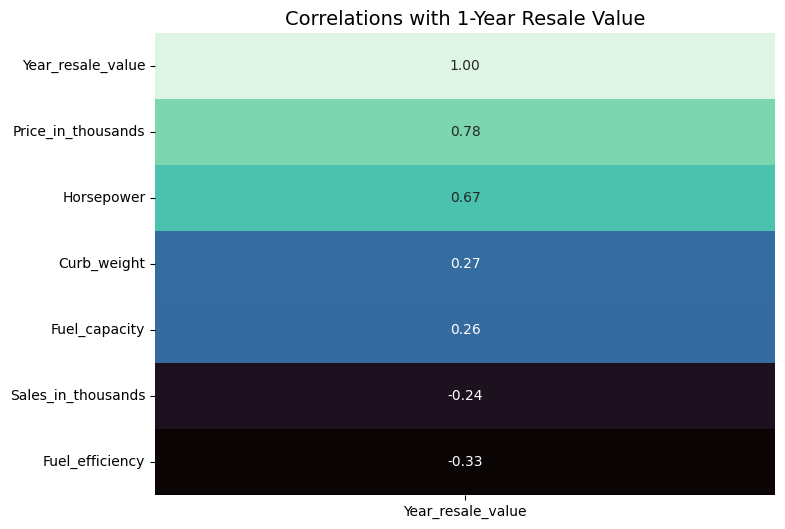

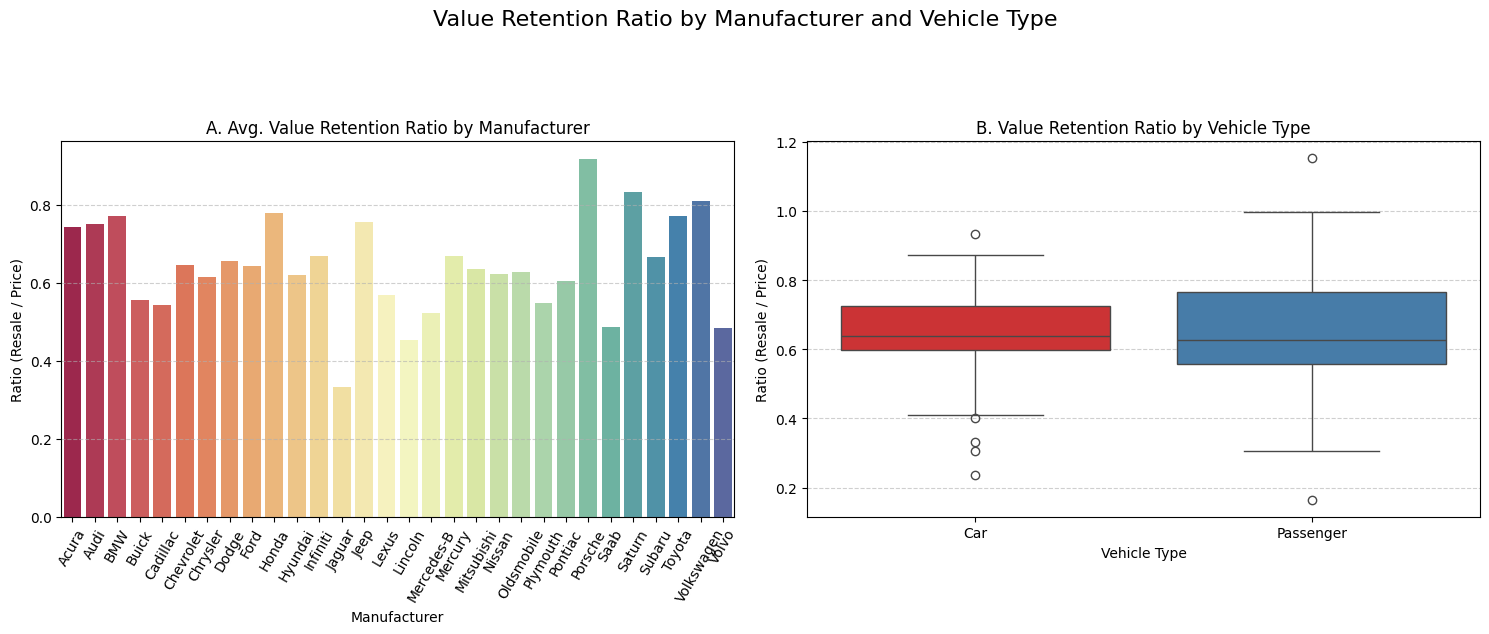

In [106]:
# ----------------------------------------------------------------------
# 1. VALUE RETENTION & DEPRECIATION DRIVERS (Core Analysis)
# ----------------------------------------------------------------------

# 1.1 Calculate Value Retention Ratio (VCRR)
df_resale_ratio = df.dropna(subset=['Year_resale_value', 'Price_in_thousands']).copy()
df_resale_ratio['Resale_Ratio'] = df_resale_ratio['Year_resale_value'] / df_resale_ratio['Price_in_thousands']


# 1.2 Q1: How do core characteristics correlate with absolute Resale Value? (Correlation)
# ----------------------------------------------------------------------
print("\n--- 1.1 Resale Value: Key Numeric Correlations ---")

resale_correlations = df[['Year_resale_value', 'Price_in_thousands', 
                          'Sales_in_thousands', 'Horsepower', 
                          'Fuel_efficiency', 'Fuel_capacity', 
                          'Curb_weight']].corr(numeric_only=True) 

plt.figure(figsize=(8, 6))
sns.heatmap(resale_correlations[['Year_resale_value']].sort_values(by='Year_resale_value', ascending=False), 
            annot=True, 
            cmap="mako", 
            fmt='.2f', 
            cbar=False)
plt.title('Correlations with 1-Year Resale Value', fontsize=14)
plt.yticks(rotation=0)
plt.show()


# 1.3 Q2: Which manufacturers and vehicle types demonstrate the best VCRR? (Barplots/Boxplots)
# ----------------------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(15, 6)) 
plt.suptitle('Value Retention Ratio by Manufacturer and Vehicle Type', fontsize=16, y=1.05)

# A. Value Retention Ratio by Manufacturer (Barplot)
resale_ratio_manufacturer = df_resale_ratio.groupby('Manufacturer', observed=True)['Resale_Ratio'].mean().sort_values(ascending=False).reset_index()

sns.barplot(
    data=resale_ratio_manufacturer,
    x='Manufacturer',
    y='Resale_Ratio',
    ax=axes[0],
    hue='Manufacturer',
    legend=False,
    palette='Spectral'
)
axes[0].set_title('A. Avg. Value Retention Ratio by Manufacturer', fontsize=12)
axes[0].set_xlabel('Manufacturer')
axes[0].set_ylabel('Ratio (Resale / Price)')
axes[0].tick_params(axis='x', rotation=60)
axes[0].grid(axis='y', linestyle='--', alpha=0.6)


# B. Value Retention Ratio by Vehicle Type (Boxplot)
sns.boxplot(
    data=df_resale_ratio,
    x="Vehicle_type",
    y="Resale_Ratio",
    ax=axes[1],
    hue="Vehicle_type",
    legend=False,
    palette='Set1'
)
axes[1].set_title('B. Value Retention Ratio by Vehicle Type', fontsize=12)
axes[1].set_xlabel('Vehicle Type')
axes[1].set_ylabel('Ratio (Resale / Price)')
axes[1].grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

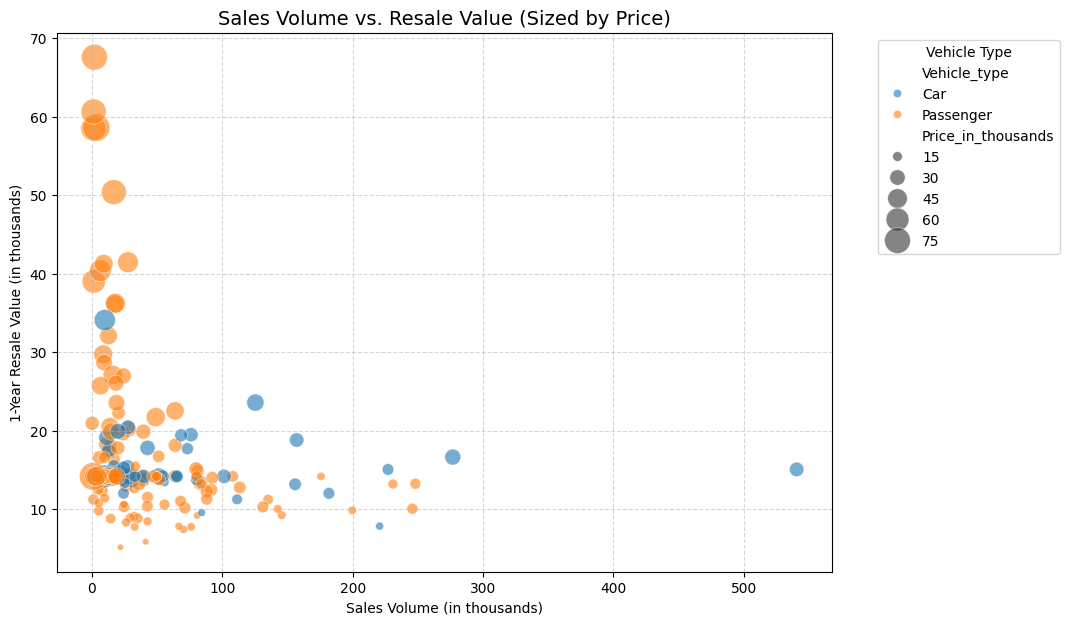

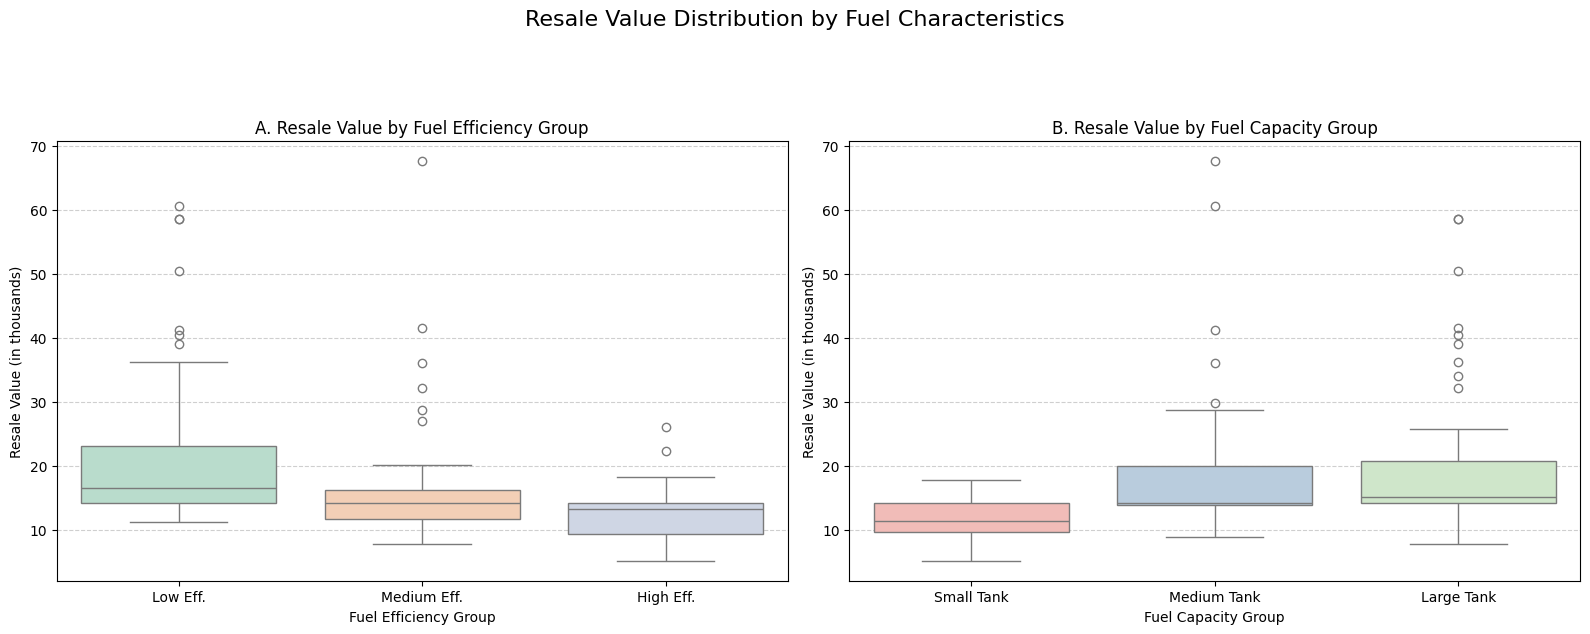

In [107]:
# ----------------------------------------------------------------------
# 2. FEATURE IMPACT & TOP PERFORMERS
# ----------------------------------------------------------------------

# 2.1 Q3: Are there top-performing models combining high sales and high resale? (Scatterplot)
# ----------------------------------------------------------------------
plt.figure(figsize=(10, 7))

sns.scatterplot(
    data=df,
    x='Sales_in_thousands',
    y='Year_resale_value',
    size='Price_in_thousands',  # Size by Price to identify high-value models
    hue='Vehicle_type',         # Color by type
    sizes=(20, 400),
    alpha=0.6
)

plt.title('Sales Volume vs. Resale Value (Sized by Price)', fontsize=14)
plt.xlabel('Sales Volume (in thousands)')
plt.ylabel('1-Year Resale Value (in thousands)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, title='Vehicle Type')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


# 2.2 Q4: Do Fuel_efficiency/Fuel_capacity affect resale? (Boxplots)
# ----------------------------------------------------------------------

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
plt.suptitle('Resale Value Distribution by Fuel Characteristics', fontsize=16, y=1.05)

# A. Resale Value by Fuel_efficiency (Binning into quantiles for Boxplot)
# We create bins/categories from the numeric column for the boxplot
df['Fuel_Eff_Group'] = pd.qcut(df['Fuel_efficiency'], q=3, labels=['Low Eff.', 'Medium Eff.', 'High Eff.'], duplicates='drop')

sns.boxplot(
    data=df,
    x='Fuel_Eff_Group',
    y='Year_resale_value',
    ax=axes[0],
    hue='Fuel_Eff_Group',
    legend=False,
    palette='Pastel2'
)
axes[0].set_title('A. Resale Value by Fuel Efficiency Group', fontsize=12)
axes[0].set_xlabel('Fuel Efficiency Group')
axes[0].set_ylabel('Resale Value (in thousands)')
axes[0].grid(axis='y', linestyle='--', alpha=0.6)


# B. Resale Value by Fuel_capacity (Binning into quantiles for Boxplot)
df['Fuel_Cap_Group'] = pd.qcut(df['Fuel_capacity'], q=3, labels=['Small Tank', 'Medium Tank', 'Large Tank'], duplicates='drop')

sns.boxplot(
    data=df,
    x='Fuel_Cap_Group',
    y='Year_resale_value',
    ax=axes[1],
    hue='Fuel_Cap_Group',
    legend=False,
    palette='Pastel1'
)
axes[1].set_title('B. Resale Value by Fuel Capacity Group', fontsize=12)
axes[1].set_xlabel('Fuel Capacity Group')
axes[1].set_ylabel('Resale Value (in thousands)')
axes[1].grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Clean up temporary grouping columns
df.drop(columns=['Fuel_Eff_Group', 'Fuel_Cap_Group'], inplace=True)


--- 3.1 Market Stability: Resale Trend Over Time ---


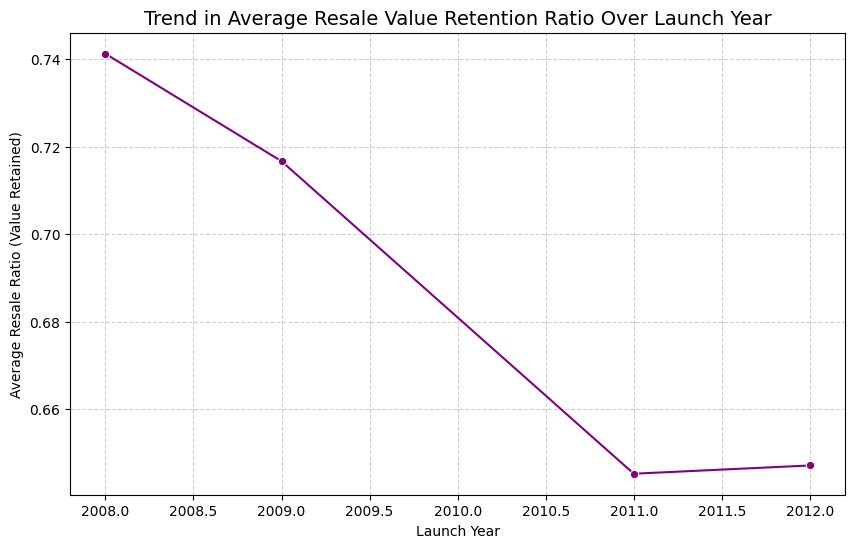

In [108]:
# ----------------------------------------------------------------------
# 3. MARKET STABILITY (TIME-SERIES)
# ----------------------------------------------------------------------

# 3.1 Q5: Are resale trends consistent across Launch_Year? (Lineplot)
# ----------------------------------------------------------------------
print("\n--- 3.1 Market Stability: Resale Trend Over Time ---")

# Ensure Launch_Year is created and ready for aggregation
if 'Launch_Year' not in df.columns:
    df['Latest_Launch'] = pd.to_datetime(df['Latest_Launch'], errors='coerce') 
    df['Launch_Year'] = df['Latest_Launch'].dt.year

# Calculate average resale ratio per year
df_resale_trend = df_resale_ratio.groupby('Launch_Year', observed=True)['Resale_Ratio'].mean().reset_index().dropna()

plt.figure(figsize=(10, 6))
sns.lineplot(
    data=df_resale_trend,
    x='Launch_Year',
    y='Resale_Ratio',
    marker='o',
    color='purple'
)
plt.title('Trend in Average Resale Value Retention Ratio Over Launch Year', fontsize=14)
plt.xlabel('Launch Year')
plt.ylabel('Average Resale Ratio (Value Retained)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()